# Energy community forecasting - Final Project 

> Group made of Ivan Duvnjak, Enkh-Oyu Nomin, Oleg Lastocichin

In [2]:
import warnings
warnings.filterwarnings('ignore')
import torch

# import useful libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss


import plotly.express as px
import statsmodels.tsa.stattools
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.graphics.api as smg
from sklearn.metrics import mean_absolute_percentage_error as mape

from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
from pmdarima import model_selection

# Probabilistic forecasts with neural models and quantile loss
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss
from neuralforecast.models import LSTM, DilatedRNN, NHITS
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Exploratory analysis

In [4]:
def read_multiple_pkl_files(file_paths):
    data_list = []
    for path in file_paths:
        try:
            with open(path, 'rb') as file:
                data = pd.read_pickle(file) # use pandas to read pickle files 
                data_list.append(data)
        except Exception as e:
            print(f"Failed to read {path}: {e}")
    return data_list

In [5]:
files = ['lic_meteo', 'lic_meters', 'lic_nwp']
datas = read_multiple_pkl_files(files)

In [6]:
df_meteo = datas[0]
df_meteo

AirPressure  AirTemp_Avg  PyrIrradiance_Avg  \
2020-01-01 00:00:00+00:00   965.453333     5.613533          -2.768667   
2020-01-01 00:15:00+00:00   965.460000     5.544867          -2.425200   
2020-01-01 00:30:00+00:00   965.353333     5.549267          -2.498133   
2020-01-01 00:45:00+00:00   965.320000     5.639200          -2.406067   
2020-01-01 01:00:00+00:00   965.300000     6.030800          -2.363267   
...                                ...          ...                ...   
2023-02-21 22:45:00+00:00   956.026667     8.393333          -0.475152   
2023-02-21 23:00:00+00:00   956.100000     8.380444          -0.492110   
2023-02-21 23:15:00+00:00   956.053778     8.293333          -0.527952   
2023-02-21 23:30:00+00:00   956.033556     8.280222          -0.395429   
2023-02-21 23:45:00+00:00   956.028000     8.340222          -0.371474   

                           Ramount_Tot  RelHumidity  WindSpeed  
2020-01-01 00:00:00+00:00          0.0    48.806667   0.617600  
2020-01-01 00:15:00+00:00          0.0    49.060000   1.238600  
2020-01-01 00:30:00+00:00          0.0    48.820000   0.854533  
2020-01-01 00:45:00+00:00          0.0    49.093333   0.923733  
2020-01-01 01:00:00+00:00          0.0    47.546667   0.916733  
...                                ...          ...        ...  
2023-02-21 22:45:00+00:00          0.0    72.532000   0.000000  
2023-02-21 23:00:00+00:00          0.0    72.653778   0.000000  
2023-02-21 23:15:00+00:00          0.0    72.733111   0.000000  
2023-02-21 23:30:00+00:00          0.0    72.953333   0.000000  
2023-02-21 23:45:00+00:00          0.0    72.813333   0.000000  

[110208 rows x 6 columns]

In [7]:
df_meters = datas[1]
df_meters

0            1            2            3        \
                           e_pos e_neg  e_pos e_neg  e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  126.0   0.0  974.0   0.0  544.0   0.0  681.0   0.0   
2020-12-31 23:15:00+00:00  102.0   0.0  211.0   0.0  495.0   0.0  606.0   0.0   
2020-12-31 23:30:00+00:00  121.0   0.0  210.0   0.0  233.0   0.0  598.0   0.0   
2020-12-31 23:45:00+00:00   98.0   0.0  291.0   0.0  449.0   0.0  624.0   0.0   
2021-01-01 00:00:00+00:00  131.0   0.0  533.0   0.0  507.0   0.0  547.0   0.0   
...                          ...   ...    ...   ...    ...   ...    ...   ...   
2022-12-31 21:45:00+00:00  112.0   0.0   96.0   0.0  218.0   0.0  140.0   0.0   
2022-12-31 22:00:00+00:00  127.0   0.0   97.0   0.0  290.0   0.0  187.0   0.0   
2022-12-31 22:15:00+00:00   95.0   0.0  109.0   0.0   72.0   0.0  215.0   0.0   
2022-12-31 22:30:00+00:00   76.0   0.0  106.0   0.0  301.0   0.0  216.0   0.0   
2022-12-31 22:45:00+00:00  119.0   0.0  110.0   0.0  203.0   0.0  312.0   0.0   

                                    4        ...      17           18        \
                                e_pos e_neg  ...   e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  142.000000   0.0  ...   670.0   0.0  808.0   0.0   
2020-12-31 23:15:00+00:00  663.000000   0.0  ...   525.0   0.0  513.0   0.0   
2020-12-31 23:30:00+00:00  437.167377   0.0  ...   499.0   0.0  436.0   0.0   
2020-12-31 23:45:00+00:00  386.815026   0.0  ...   695.0   0.0  362.0   0.0   
2021-01-01 00:00:00+00:00  390.256124   0.0  ...  1109.0   0.0  504.0   0.0   
...                               ...   ...  ...     ...   ...    ...   ...   
2022-12-31 21:45:00+00:00  147.000000   0.0  ...   841.0   0.0  146.0   0.0   
2022-12-31 22:00:00+00:00  129.000000   0.0  ...    85.0   0.0  183.0   0.0   
2022-12-31 22:15:00+00:00  138.000000   0.0  ...   219.0   0.0  161.0   0.0   
2022-12-31 22:30:00+00:00  123.000000   0.0  ...    87.0   0.0  168.0   0.0   
2022-12-31 22:45:00+00:00  194.000000   0.0  ...    75.0   0.0  184.0   0.0   

                               19       battery            PCC        
                            e_pos e_neg   e_pos e_neg    e_pos e_neg  
2020-12-31 23:00:00+00:00  1805.0   0.0     1.0   0.0   9142.0   0.0  
2020-12-31 23:15:00+00:00  3082.0   0.0     0.0   0.0  13330.0   0.0  
2020-12-31 23:30:00+00:00   881.0   0.0     1.0   0.0   9095.0   0.0  
2020-12-31 23:45:00+00:00   659.0   0.0     1.0   0.0   9380.0   0.0  
2021-01-01 00:00:00+00:00  2384.0   0.0     0.0   0.0  11750.0   0.0  
...                           ...   ...     ...   ...      ...   ...  
2022-12-31 21:45:00+00:00  2157.0   0.0    35.0   0.0   7130.0   0.0  
2022-12-31 22:00:00+00:00   968.0   0.0    34.0   0.0   6120.0   0.0  
2022-12-31 22:15:00+00:00   655.0   0.0    35.0   0.0   5111.0   0.0  
2022-12-31 22:30:00+00:00  1318.0   0.0    36.0   0.0   4657.0   0.0  
2022-12-31 22:45:00+00:00  2894.0   0.0    32.0   0.0   7745.0   0.0  

[70080 rows x 44 columns]

In [8]:
df_nwp = datas[2]
df_nwp

ghi_backwards                                   \
                                    0       1       10     100  101  102   
2020-01-01 00:00:00+00:00          0.00    0.00  273.43   0.00  0.0  0.0   
2020-01-01 12:00:00+00:00        354.10  314.48    0.00  33.83  0.0  0.0   
2020-01-02 00:00:00+00:00          0.00    0.00  265.03   0.00  0.0  0.0   
2020-01-02 12:00:00+00:00        345.37  307.64    0.00  34.66  0.0  0.0   
2020-01-03 00:00:00+00:00          0.00    0.00   60.56   0.00  0.0  0.0   
...                                 ...     ...     ...    ...  ...  ...   
2023-02-19 00:00:00+00:00          0.00    0.00  344.87   0.00  0.0  0.0   
2023-02-20 00:00:00+00:00          0.00    0.00  189.44   0.00  0.0  0.0   
2023-02-21 00:00:00+00:00          0.00    0.00  452.66   0.00  0.0  0.0   
2023-02-22 00:00:00+00:00          0.00    0.00  132.73   0.00  0.0  0.0   
2023-02-23 00:00:00+00:00          0.00    0.00  420.29   0.00  0.0  0.0   

                                                          ... temperature  \
                             103     104     105     106  ...         90    
2020-01-01 00:00:00+00:00   0.00   26.58  127.41  234.86  ...        5.27   
2020-01-01 12:00:00+00:00   0.00    0.00    0.00    0.00  ...        0.44   
2020-01-02 00:00:00+00:00   0.00   25.69  124.16  229.88  ...        3.81   
2020-01-02 12:00:00+00:00   0.00    0.00    0.00    0.00  ...        0.83   
2020-01-03 00:00:00+00:00   0.00   25.68  121.78  221.89  ...        2.87   
...                          ...     ...     ...     ...  ...         ...   
2023-02-19 00:00:00+00:00   6.53   41.74   86.72  123.88  ...        8.62   
2023-02-20 00:00:00+00:00   7.78   47.06   99.28  163.44  ...        8.05   
2023-02-21 00:00:00+00:00  20.73  137.38  297.33  435.27  ...        8.33   
2023-02-22 00:00:00+00:00  16.48  107.13  231.32  339.49  ...        9.09   
2023-02-23 00:00:00+00:00  15.24   82.81  168.08  234.96  ...        0.54   

                                                                           \
                            91    92    93    94    95    96    97    98    
2020-01-01 00:00:00+00:00  4.30  3.57  3.00  2.57  2.21  1.88  1.59  1.32   
2020-01-01 12:00:00+00:00  1.49  2.98  4.72  6.54  8.30  9.51  9.81  9.15   
2020-01-02 00:00:00+00:00  2.69  1.60  0.62 -0.21 -0.31 -0.11  0.37  0.50   
2020-01-02 12:00:00+00:00  1.70  2.81  4.09  5.42  6.75  7.58  7.72  7.12   
2020-01-03 00:00:00+00:00  2.05  1.34  0.72  0.24 -0.08 -0.26 -0.26 -0.15   
...                         ...   ...   ...   ...   ...   ...   ...   ...   
2023-02-19 00:00:00+00:00  7.85  7.44  7.12  6.98  6.66  6.35  5.91  5.64   
2023-02-20 00:00:00+00:00  7.37  7.05  6.80  6.65  6.34  6.03  5.59  5.24   
2023-02-21 00:00:00+00:00  7.47  7.00  6.68  6.50  6.17  5.76  5.08  4.41   
2023-02-22 00:00:00+00:00  7.54  6.46  5.71  5.17  4.53  3.94  3.37  3.13   
2023-02-23 00:00:00+00:00 -0.08 -0.52 -0.88 -1.30 -1.69 -1.94 -2.06 -2.17   

                                 
                            99   
2020-01-01 00:00:00+00:00  1.08  
2020-01-01 12:00:00+00:00  7.88  
2020-01-02 00:00:00+00:00  0.67  
2020-01-02 12:00:00+00:00  6.15  
2020-01-03 00:00:00+00:00  0.06  
...                         ...  
2023-02-19 00:00:00+00:00  5.38  
2023-02-20 00:00:00+00:00  4.88  
2023-02-21 00:00:00+00:00  3.65  
2023-02-22 00:00:00+00:00  2.82  
2023-02-23 00:00:00+00:00 -2.29  

[2024 rows x 507 columns]

In [9]:
def check_data(df):
    print(df.shape)
    print("Null values: ", df.isna().sum().sum())
    print("Duplicated values: ", df.duplicated().sum().sum())

In [10]:
for i, data in enumerate(datas):
    print(f"Dataset {i}: ")
    check_data(data)
    print()

Dataset 0: 
(110208, 6)
Null values:  26022
Duplicated values:  4336

Dataset 1: 
(70080, 44)
Null values:  1269
Duplicated values:  0

Dataset 2: 
(2024, 507)
Null values:  0
Duplicated values:  0



As we can see, in our main dataset (df_meters) we have only few missing values regarding the total amount of data available and no duplicated values. Therefore, we will manage later the missing values accordingly or eventually manage them through the parameter of the models (missing='drop').

In [11]:
df_meteo.describe()

AirPressure    AirTemp_Avg  PyrIrradiance_Avg    Ramount_Tot  \
count  105871.000000  105871.000000      105871.000000  105871.000000   
mean      954.561192      12.120143         154.129589       0.000080   
std         7.442895       7.651406         245.033296       0.000807   
min       922.514000      -5.294667          -6.768882       0.000000   
25%       950.721444       5.902222          -2.007937       0.000000   
50%       955.070000      11.581111           1.639702       0.000000   
75%       959.293556      17.933444         248.432000       0.000000   
max       978.993333      33.752222        1113.562222       0.033778   

         RelHumidity      WindSpeed  
count  105871.000000  105871.000000  
mean       58.166503       0.529281  
std        19.621741       0.803295  
min         5.264889       0.000000  
25%        42.935222       0.000000  
50%        59.492222       0.000000  
75%        74.538667       0.856444  
max        89.799333       9.138600

In [12]:
df_meters.describe()

0                      1                           2  \
              e_pos    e_neg         e_pos         e_neg         e_pos   
count  70076.000000  70076.0  70075.000000  70075.000000  70074.000000   
mean     107.824081      0.0    272.290030    249.314922    290.711487   
std      135.347667      0.0    387.109223    456.124190    311.976442   
min        6.000000      0.0      0.000000      0.000000     16.000000   
25%       36.000000      0.0      0.000000      0.000000     75.000000   
50%       64.000000      0.0     81.000000      0.000000    198.000000   
75%      110.000000      0.0    380.000000    295.000000    353.000000   
max     1427.000000      0.0   2999.000000   2205.000000   2299.000000   

                           3                           4                ...  \
         e_neg         e_pos         e_neg         e_pos         e_neg  ...   
count  70074.0  70075.000000  70075.000000  70072.000000  70072.000000  ...   
mean       0.0    474.286114    223.848708    166.675116     15.549249  ...   
std        0.0    550.662753    493.012259    224.110238    105.581205  ...   
min        0.0      0.000000      0.000000      0.000000      0.000000  ...   
25%        0.0     99.000000      0.000000     65.000000      0.000000  ...   
50%        0.0    263.000000      0.000000     97.000000      0.000000  ...   
75%        0.0    664.000000     77.000000    162.000000      0.000000  ...   
max        0.0   5518.000000   2523.000000   2476.000000   1384.000000  ...   

                 17                     18                     19  \
              e_pos    e_neg         e_pos    e_neg         e_pos   
count  70076.000000  70076.0  69796.000000  69796.0  70079.000000   
mean     623.854193      0.0    255.937860      0.0   1945.517937   
std      641.550945      0.0    345.092742      0.0   1966.557857   
min       20.000000      0.0      2.000000      0.0      0.000000   
25%       79.000000      0.0     36.000000      0.0    651.000000   
50%      462.000000      0.0    172.000000      0.0   1189.000000   
75%      921.000000      0.0    253.000000      0.0   2758.000000   
max     4794.000000      0.0   2445.000000      0.0  18001.000000   

                          battery                         PCC                
              e_neg         e_pos         e_neg         e_pos         e_neg  
count  70079.000000  70039.000000  70039.000000  69846.000000  69841.000000  
mean     102.683129     89.390494     57.457933   6993.379320    257.127447  
std      313.095704    602.753188    453.924218   5245.573242    869.503439  
min        0.000000   -165.116671      0.000000      0.000000      0.000000  
25%        0.000000      1.000000      0.000000   2829.000000      0.000000  
50%        0.000000     32.000000      0.000000   5951.000000      0.000000  
75%        0.000000     36.000000      0.000000  10358.000000      0.000000  
max     3855.000000  13152.000000  12927.000000  32061.000000  10075.000000  

[8 rows x 44 columns]

In [13]:
df_nwp.describe()

ghi_backwards                                                      \
                0            1            10           100          101   
count   2024.000000  2024.000000  2024.000000  2024.000000  2024.000000   
mean     260.782258   242.399402   264.685390   112.370455    70.186621   
std      335.197101   314.063051   304.667198   162.917482   104.222232   
min        0.000000     0.000000     0.000000     0.000000     0.000000   
25%        0.000000     0.000000     0.000000     0.000000     0.000000   
50%        0.000000     0.000000   110.355000     2.520000    12.165000   
75%      534.397500   494.395000   519.910000   214.062500    92.097500   
max      979.900000   938.610000   926.020000   571.250000   399.410000   

                                                                        ...  \
               102          103          104          105          106  ...   
count  2024.000000  2024.000000  2024.000000  2024.000000  2024.000000  ...   
mean     57.885059    79.938394   131.976542   192.819545   244.074872  ...   
std      69.018230   113.330489   174.179933   224.530964   267.054146  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%      20.725000    17.975000    28.270000   113.905000   196.145000  ...   
75%     111.515000   123.462500   250.422500   366.190000   463.715000  ...   
max     229.770000   413.140000   591.030000   740.950000   856.020000  ...   

       temperature                                                      \
               90           91           92           93           94    
count  2024.000000  2024.000000  2024.000000  2024.000000  2024.000000   
mean     12.589091    12.753137    13.092080    13.488157    13.811922   
std       8.108679     8.018484     8.027235     8.159245     8.375144   
min      -5.560000    -4.510000    -2.980000    -3.520000    -4.100000   
25%       5.705000     5.660000     5.882500     6.347500     6.845000   
50%      12.630000    12.990000    13.290000    13.575000    13.830000   
75%      19.572500    20.067500    20.240000    20.212500    20.235000   
max      30.300000    28.520000    29.780000    31.980000    33.780000   

                                                                        
               95           96           97           98           99   
count  2024.000000  2024.000000  2024.000000  2024.000000  2024.000000  
mean     14.010469    14.063715    13.949990    13.662569    13.187134  
std       8.623192     8.826487     8.985447     9.067328     9.048708  
min      -4.580000    -4.950000    -5.190000    -5.420000    -5.650000  
25%       7.177500     7.197500     6.907500     6.420000     5.965000  
50%      13.955000    14.045000    13.960000    13.575000    13.090000  
75%      20.232500    20.135000    19.982500    19.760000    19.335000  
max      34.780000    35.270000    35.310000    35.680000    35.650000  

[8 rows x 507 columns]

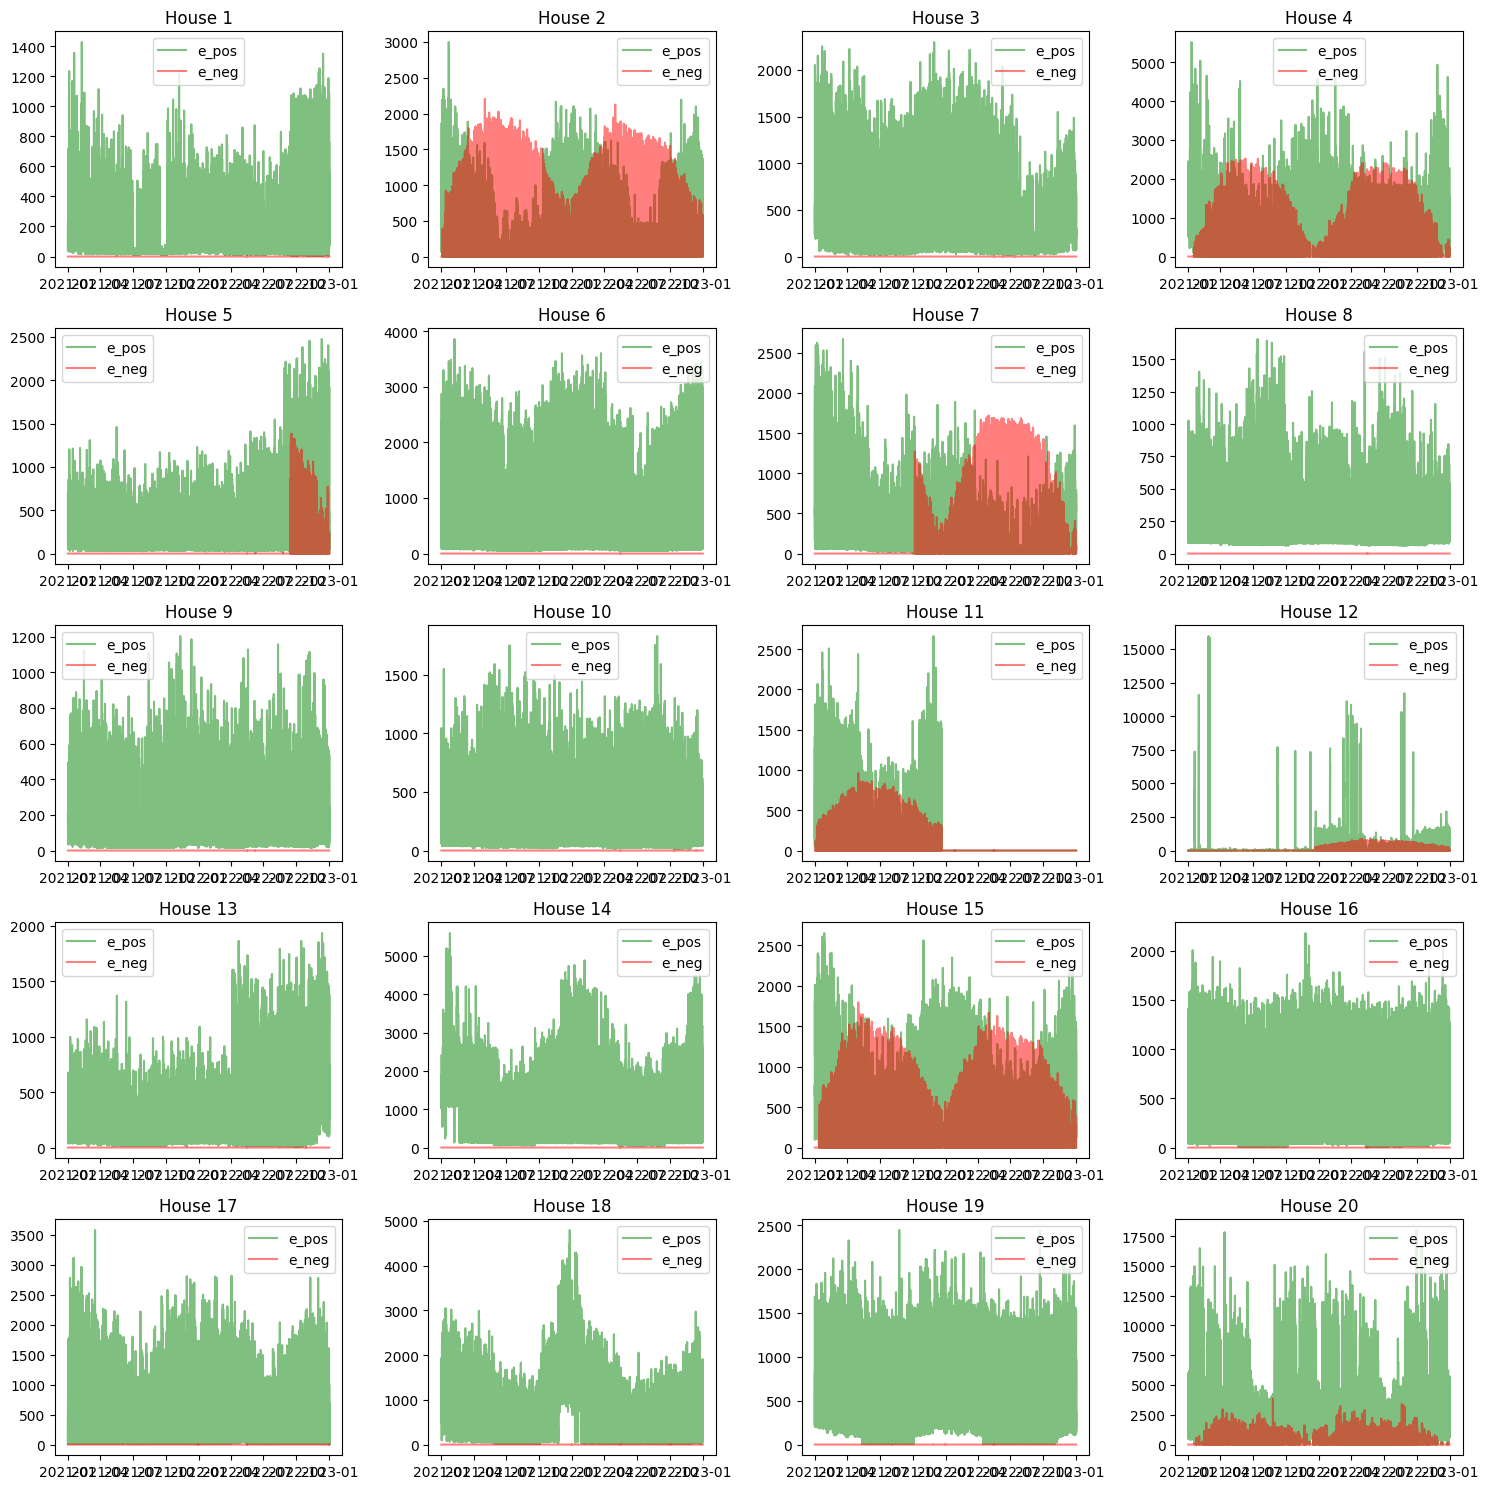

In [14]:
fig, axs = plt.subplots(5, 4, figsize=(15, 15))
axs = axs.ravel()

for i in range(20):
    axs[i].plot(df_meters[i]["e_pos"], color='green', alpha=0.5, label='e_pos')
    axs[i].plot(df_meters[i]["e_neg"], color='red', alpha=0.5, label='e_neg')
    axs[i].set_title(f"House {i+1}")
    axs[i].legend() 

plt.tight_layout() 
plt.show()

We see that not all houses have values for n_neg, most of them don't. Those that have some values, some follow some seasonality 

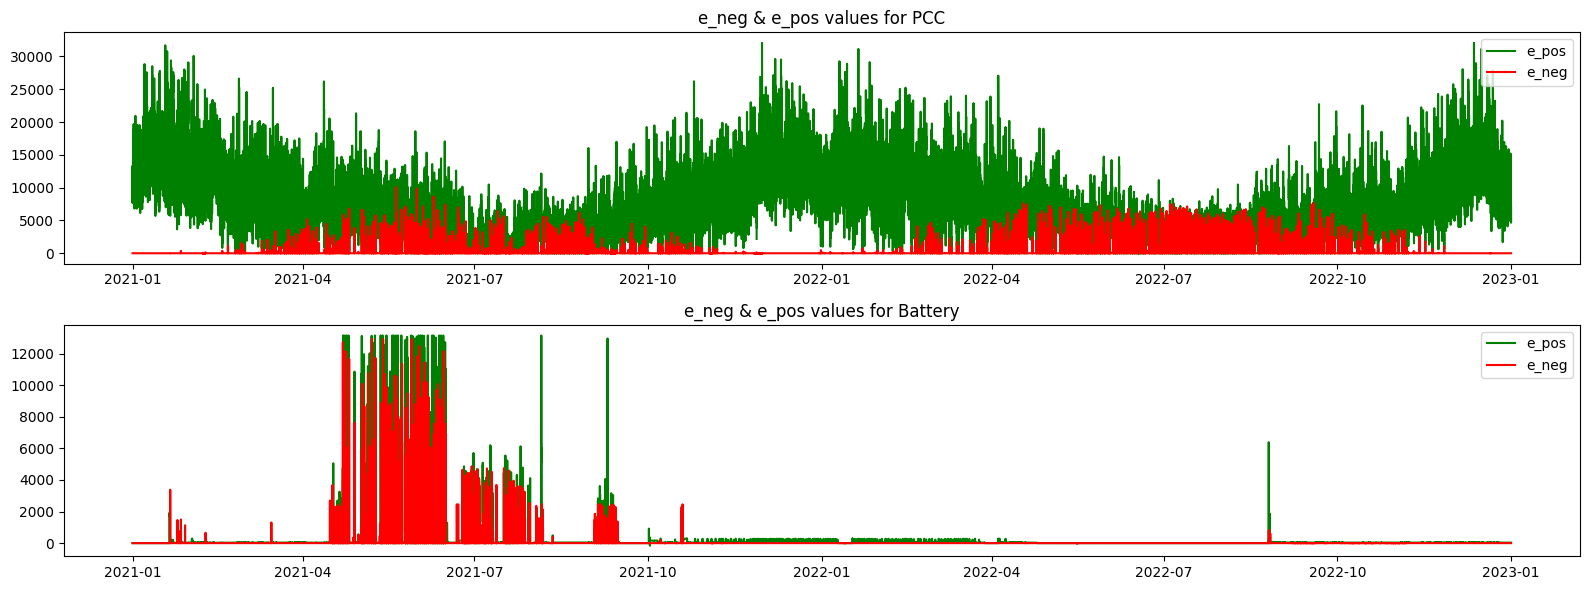

In [15]:
# plot values of e_pos & e_neg for "PCC" and "battery"

fig, axs = plt.subplots(nrows=2, figsize=(16, 6))

axs[0].plot(df_meters["PCC"]["e_pos"], color='green', label='e_pos')
axs[0].plot(df_meters["PCC"]["e_neg"], color='red', label='e_neg')
axs[0].set_title('e_neg & e_pos values for PCC') 
axs[0].legend()

axs[1].plot(df_meters["battery"]["e_pos"], color='green', label='e_pos')
axs[1].plot(df_meters["battery"]["e_neg"], color='red', label='e_neg')
axs[1].set_title('e_neg & e_pos values for Battery')  
axs[1].legend()

plt.tight_layout()
plt.show()

We can confirm from the previous plots that e_neg & e_pos are not mutually exclusive. Moreover, most households have e_neg = 0 during the whole time series.

**PCC**: There appears to be a cyclical pattern in the data, possibly indicating seasonal variations in energy usage or production. For example, the peaks in energy seem to repeat annually. The red bars which represent "e_neg" are significantly smaller and less frequent compared to the positive values. This indicates that instances of negative energy (energy injected back to the grid) are much less common.

**Battery**: Unlike the PCC, the battery system shows significant fluctuations between positive and negative energy values. The "e_neg" values, particularly, are much more prominent here than in the PCC plot. There are several sharp spikes in both "e_pos" and "e_neg", which could indicate charging and discharging cycles of the battery. These spikes could also reflect responses to demand shifts or operational adjustments.

### Data Preparation - Hourly utilization

In [16]:
# create utilization for all houses, battery, pcc and store as columns in dataframe
pdf_meters = pd.DataFrame()

for ind in df_meters.columns.levels[0].to_list():
    df = df_meters[ind]

    df = df.resample('H').mean().dropna()
    df['e_utilization'+ "_" + str(ind)] = df['e_pos'] + df['e_neg'] #define utilization
    df = df.drop(['e_pos','e_neg'],axis=1)

    pdf_meters = pd.concat([pdf_meters,df],axis=1)

pdf_meters

e_utilization_0  e_utilization_1  e_utilization_2  \
2020-12-31 23:00:00+00:00           111.75           421.50           430.25   
2021-01-01 00:00:00+00:00           121.25           202.50           465.50   
2021-01-01 01:00:00+00:00            54.50           358.25           419.75   
2021-01-01 02:00:00+00:00            56.00           511.50           437.25   
2021-01-01 03:00:00+00:00            71.75           422.00           469.75   
...                                    ...              ...              ...   
2022-12-31 18:00:00+00:00           259.50           628.50           378.25   
2022-12-31 19:00:00+00:00           137.25            88.75           211.00   
2022-12-31 20:00:00+00:00           261.25            90.50           240.00   
2022-12-31 21:00:00+00:00           106.50            98.75           194.00   
2022-12-31 22:00:00+00:00           104.25           105.50           216.50   

                           e_utilization_3  e_utilization_4  e_utilization_5  \
2020-12-31 23:00:00+00:00           627.25       407.245601           956.00   
2021-01-01 00:00:00+00:00           617.25       361.395305           364.25   
2021-01-01 01:00:00+00:00           582.50       329.359094           823.00   
2021-01-01 02:00:00+00:00           614.25       296.250000           257.25   
2021-01-01 03:00:00+00:00           530.75       139.500000           106.25   
...                                    ...              ...              ...   
2022-12-31 18:00:00+00:00           653.25      1190.500000           292.50   
2022-12-31 19:00:00+00:00           780.75       424.000000          1023.25   
2022-12-31 20:00:00+00:00           591.00       450.500000           309.00   
2022-12-31 21:00:00+00:00           458.00       202.250000           952.00   
2022-12-31 22:00:00+00:00           232.50       146.000000           645.50   

                           e_utilization_6  e_utilization_7  e_utilization_8  \
2020-12-31 23:00:00+00:00           556.75           196.50           145.50   
2021-01-01 00:00:00+00:00           827.75           198.50           139.75   
2021-01-01 01:00:00+00:00           759.75           164.75           158.50   
2021-01-01 02:00:00+00:00           479.75           119.25           171.25   
2021-01-01 03:00:00+00:00           648.00           102.50            72.00   
...                                    ...              ...              ...   
2022-12-31 18:00:00+00:00           398.75           168.75           380.00   
2022-12-31 19:00:00+00:00           254.00           164.00           357.50   
2022-12-31 20:00:00+00:00           257.25           140.75           214.75   
2022-12-31 21:00:00+00:00           171.50           118.75           121.75   
2022-12-31 22:00:00+00:00            57.00           101.75            86.75   

                           e_utilization_9  ...  e_utilization_12  \
2020-12-31 23:00:00+00:00           179.00  ...             53.75   
2021-01-01 00:00:00+00:00           211.75  ...             55.50   
2021-01-01 01:00:00+00:00           393.50  ...             55.50   
2021-01-01 02:00:00+00:00           207.00  ...             61.25   
2021-01-01 03:00:00+00:00            85.25  ...             51.25   
...                                    ...  ...               ...   
2022-12-31 18:00:00+00:00            86.50  ...            878.00   
2022-12-31 19:00:00+00:00            75.00  ...            560.00   
2022-12-31 20:00:00+00:00            78.75  ...            357.25   
2022-12-31 21:00:00+00:00            82.50  ...            361.75   
2022-12-31 22:00:00+00:00            68.75  ...            313.50   

                           e_utilization_13  e_utilization_14  \
2020-12-31 23:00:00+00:00           1130.50            705.00   
2021-01-01 00:00:00+00:00           1161.00            453.75   
2021-01-01 01:00:00+00:00           1047.75            664.25   
2021-01-01 02:00:00+00:00           1037.00            

In [ ]:
fig = px.line(pdf_meters, title='PCC e_utilization')
fig

### Check for Lags which have highest correlation

In [18]:
# Compute Auto correlation 
acf_df = pd.DataFrame()
for cl in pdf_meters.columns:
    acf = pd.DataFrame()
    acf[cl] = statsmodels.tsa.stattools.acf(pdf_meters[cl], missing="drop", nlags=24) # Auto correlation function
    acf_df = pd.concat([acf_df, acf], axis=1)
acf_df

e_utilization_0  e_utilization_1  e_utilization_2  e_utilization_3  \
0          1.000000         1.000000         1.000000         1.000000   
1          0.671287         0.790672         0.442184         0.706924   
2          0.509248         0.608547         0.361917         0.471036   
3          0.401099         0.431875         0.312841         0.323779   
4          0.308489         0.272320         0.277480         0.206693   
5          0.230217         0.124576         0.261565         0.113516   
6          0.173782        -0.002916         0.250670         0.033205   
7          0.148078        -0.119406         0.254566        -0.038362   
8          0.142584        -0.215456         0.270739        -0.081771   
9          0.143805        -0.288097         0.279873        -0.100246   
10         0.144180        -0.322624         0.283602        -0.105097   
11         0.151555        -0.321307         0.301406        -0.101036   
12         0.160096        -0.311352         0.307775        -0.094600   
13         0.145453        -0.322677         0.307522        -0.101674   
14         0.136364        -0.327068         0.286897        -0.105076   
15         0.130815        -0.290964         0.280604        -0.102980   
16         0.140065        -0.224200         0.274082        -0.087147   
17         0.138684        -0.131887         0.255366        -0.040398   
18         0.159044        -0.027874         0.243829         0.022965   
19         0.200648         0.092623         0.243207         0.095811   
20         0.260422         0.225299         0.264108         0.177963   
21         0.312770         0.369422         0.295980         0.272430   
22         0.379310         0.518408         0.342879         0.374351   
23         0.455993         0.665845         0.388596         0.502142   
24         0.498167         0.745472         0.409770         0.583396   

    e_utilization_4  e_utilization_5  e_utilization_6  e_utilization_7  \
0          1.000000         1.000000         1.000000         1.000000   
1          0.623881         0.511789         0.824648         0.756150   
2          0.363559         0.302662         0.697902         0.521848   
3          0.261940         0.219176         0.552145         0.373285   
4          0.207030         0.179249         0.414248         0.301173   
5          0.164829         0.141576         0.294299         0.247793   
6          0.135021         0.106502         0.189039         0.150757   
7          0.109181         0.103331         0.102276         0.093959   
8          0.085542         0.124430         0.043261         0.061873   
9          0.076435         0.173548         0.016718        -0.015023   
10         0.078830         0.214243         0.008518        -0.110348   
11         0.074590         0.250114         0.018706        -0.189045   
12         0.079038         0.304906         0.018133        -0.226065   
13         0.085732         0.267618         0.013841        -0.187556   
14         0.088367         0.212322         0.002554        -0.105985   
15         0.093609         0.166140         0.004857        -0.008208   
16         0.105731         0.120935         0.030695         0.069138   
17         0.118944         0.104506         0.086669         0.097870   
18         0.149864         0.116319         0.163244         0.149207   
19         0.185446         0.141972         0.259090         0.238276   
20         0.221606         0.172184         0.370552         0.279880   
21         0.268358         0.232800         0.490135         0.330837   
22         0.316467         0.305575         0.616210         0.447277   
23         0.365036         0.410517         0.717301         0.644144   
24         0.396961         0.498913         0.776936         0.793075   

    e_utilization_8  e_utilization_9  ...  e_utilization_12  e_utilization_13  \
0          1.000000         1.000000  ...          1.000000          1.00

In [ ]:
fig = px.line(acf_df, title='ACF e_utilization')
fig

In [20]:
top5lags = acf_df.apply(lambda x: pd.Series(x.nlargest(5).index), axis=0)
top5lags 

e_utilization_0  e_utilization_1  e_utilization_2  e_utilization_3  \
0                0                0                0                0   
1                1                1                1                1   
2                2               24               24               24   
3               24               23               23               23   
4               23                2                2                2   

   e_utilization_4  e_utilization_5  e_utilization_6  e_utilization_7  \
0                0                0                0                0   
1                1                1                1               24   
2               24               24               24                1   
3               23               23               23               23   
4                2               22                2                2   

   e_utilization_8  e_utilization_9  ...  e_utilization_12  e_utilization_13  \
0                0                0  ...                 0                 0   
1                1                1  ...                24                 2   
2                2               24  ...                 1                 1   
3                3               23  ...                23                24   
4                4                2  ...                 2                23   

   e_utilization_14  e_utilization_15  e_utilization_16  e_utilization_17  \
0                 0                 0                 0                 0   
1                 1                 1                 1                 1   
2                24                 2                24                 2   
3                23                24                23                24   
4                 2                23                 2                 3   

   e_utilization_18  e_utilization_19  e_utilization_battery  \
0                 0                 0                      0   
1                24                 1                      1   
2                 1                24                     24   
3                13                 2                     23   
4                11                23                      2   

   e_utilization_PCC  
0                  0  
1                  1  
2                 24  
3                  2  
4                 23  

[5 rows x 22 columns]

 We confirm from above auto-correlation analysis that lags 1 and 24 are the most important. This confirms common understanding that energy usage is deterministic from last hour's usage and last day's from same time. 

### Understand relationship between houses and PCC

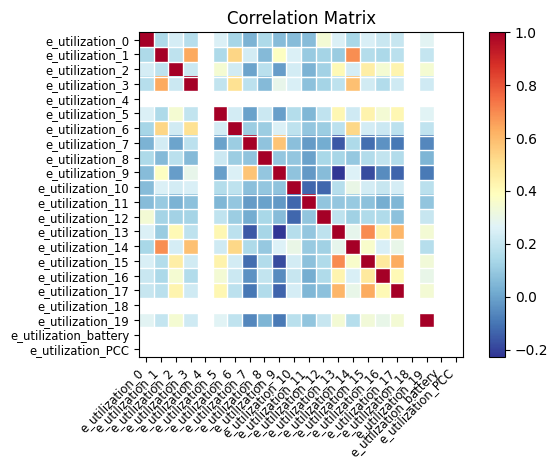

In [21]:
# Correlation across series
names = pdf_meters.columns.values
corr_matrix = np.corrcoef(pdf_meters.T)
fig = smg.plot_corr(corr_matrix,xnames=names)
# Overall there exist moderate correlation between different series

#### Test if series are stationary
https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

**ADF test** - used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not

**H0**: The series has a unit root.

**H1**: The series has no unit root.

If the null hypothesis is failed to be rejected, this test may provide evidence that the series is non-stationary.

In [23]:
# function to return me the non-stationary features by using ADF

def check_stationarity_adf(dataframe):
    non_stationary_columns = []  # List to hold names of non-stationary columns

    for column in dataframe.columns:
        dftest = adfuller(dataframe[column].dropna(), autolag='AIC')  # Dropping NA values to avoid errors

        # Check if the p-value indicates non-stationarity
        if dftest[1] > 0.05:  # p-value greater than 0.05 suggests non-stationarity
            non_stationary_columns.append(column)

    # Print the results after checking all columns
    if non_stationary_columns:
        print(f'Non-stationary columns: {", ".join(non_stationary_columns)}')
    else:
        print("All features are stationary.")

In [24]:
check_stationarity_adf(pdf_meters)

All features are stationary.


KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

**KPSS test**

**H0**: The process is trend stationary.

**H1**: The series has a unit root (series is not stationary).

In [26]:
# function to return me the non-stationary features by using KPSS

def kpss_test(dataframe, **kw):
    non_stationary_columns = []  # List to store non-stationary columns

    # Loop through each column in the DataFrame
    for column in dataframe.columns:
        series = dataframe[column].dropna()  # Drop NA values to avoid errors
        if len(series) == 0:
            print(f"Column {column} only contains NaNs")
            continue
        
        try:
            statistic, p_value, n_lags, critical_values = kpss(series, **kw)
            print(f'KPSS Test Results for {column}:')
            print(f'KPSS Statistic: {statistic}')
            print(f'p-value: {p_value}')
            print(f'num lags: {n_lags}')
            print('Critical Values:')
            for key, value in critical_values.items():
                print(f'    {key} : {value}')
            
            # Determine if the series is non-stationary based on the p-value
            if p_value < 0.05:
                non_stationary_columns.append(column)
                print(f'Result: The series {column} is not stationary\n')
            else:
                print(f'Result: The series {column} is stationary\n')

        except ValueError as e:  # Catch errors related to insufficient data
            print(f"Error testing {column}: {e}")

    # Print all non-stationary columns at the end of the function execution
    if non_stationary_columns:
        print(f'Non-stationary columns: {", ".join(non_stationary_columns)}')
    else:
        print("All columns are stationary.")

In [27]:
kpss_test(pdf_meters)

KPSS Test Results for e_utilization_0:
KPSS Statistic: 2.17069555277559
p-value: 0.01
num lags: 58
Critical Values:
    10% : 0.347
    5% : 0.463
    2.5% : 0.574
    1% : 0.739
Result: The series e_utilization_0 is not stationary

KPSS Test Results for e_utilization_1:
KPSS Statistic: 2.420777018645682
p-value: 0.01
num lags: 30
Critical Values:
    10% : 0.347
    5% : 0.463
    2.5% : 0.574
    1% : 0.739
Result: The series e_utilization_1 is not stationary

KPSS Test Results for e_utilization_2:
KPSS Statistic: 4.123980994591291
p-value: 0.01
num lags: 67
Critical Values:
    10% : 0.347
    5% : 0.463
    2.5% : 0.574
    1% : 0.739
Result: The series e_utilization_2 is not stationary

KPSS Test Results for e_utilization_3:
KPSS Statistic: 2.1747841052240595
p-value: 0.01
num lags: 38
Critical Values:
    10% : 0.347
    5% : 0.463
    2.5% : 0.574
    1% : 0.739
Result: The series e_utilization_3 is not stationary

KPSS Test Results for e_utilization_4:
KPSS Statistic: 13.851123

KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

In [ ]:
# def make_stationary_differencing(dataframe):
#     stationary_df = pd.DataFrame()
#     for column in dataframe.columns:
#         stationary_df[column] = dataframe[column] - dataframe[column].shift(1)

#     # dropping the first row which will always be NaN due to differencing
#     stationary_df = stationary_df.dropna()

#     return stationary_df

# stationary_meters = make_stationary_differencing(pdf_meters)

In [ ]:
# # an example of a feature to verify the result
# stationary_meters["e_utilization_PCC"].plot(figsize=(12, 8))
# plt.title("Differentiated e_utilization_PCC")
# plt.show()

In [ ]:
# # an example of a feature to verify the result
# stationary_meters["e_utilization_0"].plot(figsize=(12, 8))
# plt.title("Differentiated e_utilization_0")
# plt.show()

In [ ]:
# pdf_meters["e_utilization_PCC"] = pdf_meters["e_utilization_PCC"] - pdf_meters["e_utilization_PCC"].shift(1)
# pdf_meters["e_utilization_PCC"].dropna().plot(figsize=(12, 8))

In [ ]:
# check_stationarity_adf(stationary_meters) # Check again stationarity after differencing

In [ ]:
# kpss_test(stationary_meters)

In [ ]:
# check_stationarity_adf(pdf_meters["e_utilization_PCC"].dropna())

In [ ]:
# kpss_test(pdf_meters["e_utilization_PCC"].dropna())

As you can see above, the series is difference stationary and we have tried to difference them in order to check if the models improved. We got little to no improvements in the models' performances. Therefore, we left the models that we have performed initially that manage the differencing within the model as you will see below.

## Model benchmark

In [37]:
losses_mse_all = {}
losses_mae_all = {}

#### Naive method - take the last value as forecast

In [38]:
nv_fit = pd.DataFrame()
nv_fit = pdf_meters.shift(1) # Set the prediction as previous values 
nv_fit.columns = "Fitted_" + nv_fit.columns
nv_fit = pd.concat([pdf_meters, nv_fit],axis=1)
nv_fit = nv_fit.dropna()
nv_fit

e_utilization_0  e_utilization_1  e_utilization_2  \
2021-01-01 00:00:00+00:00           121.25           202.50           465.50   
2021-01-01 01:00:00+00:00            54.50           358.25           419.75   
2021-01-01 02:00:00+00:00            56.00           511.50           437.25   
2021-01-01 03:00:00+00:00            71.75           422.00           469.75   
2021-01-01 04:00:00+00:00            56.75           440.50           499.50   
...                                    ...              ...              ...   
2022-12-31 18:00:00+00:00           259.50           628.50           378.25   
2022-12-31 19:00:00+00:00           137.25            88.75           211.00   
2022-12-31 20:00:00+00:00           261.25            90.50           240.00   
2022-12-31 21:00:00+00:00           106.50            98.75           194.00   
2022-12-31 22:00:00+00:00           104.25           105.50           216.50   

                           e_utilization_3  e_utilization_4  e_utilization_5  \
2021-01-01 00:00:00+00:00           617.25       361.395305           364.25   
2021-01-01 01:00:00+00:00           582.50       329.359094           823.00   
2021-01-01 02:00:00+00:00           614.25       296.250000           257.25   
2021-01-01 03:00:00+00:00           530.75       139.500000           106.25   
2021-01-01 04:00:00+00:00          1212.50       130.500000           609.75   
...                                    ...              ...              ...   
2022-12-31 18:00:00+00:00           653.25      1190.500000           292.50   
2022-12-31 19:00:00+00:00           780.75       424.000000          1023.25   
2022-12-31 20:00:00+00:00           591.00       450.500000           309.00   
2022-12-31 21:00:00+00:00           458.00       202.250000           952.00   
2022-12-31 22:00:00+00:00           232.50       146.000000           645.50   

                           e_utilization_6  e_utilization_7  e_utilization_8  \
2021-01-01 00:00:00+00:00           827.75           198.50           139.75   
2021-01-01 01:00:00+00:00           759.75           164.75           158.50   
2021-01-01 02:00:00+00:00           479.75           119.25           171.25   
2021-01-01 03:00:00+00:00           648.00           102.50            72.00   
2021-01-01 04:00:00+00:00           837.75           100.50            79.25   
...                                    ...              ...              ...   
2022-12-31 18:00:00+00:00           398.75           168.75           380.00   
2022-12-31 19:00:00+00:00           254.00           164.00           357.50   
2022-12-31 20:00:00+00:00           257.25           140.75           214.75   
2022-12-31 21:00:00+00:00           171.50           118.75           121.75   
2022-12-31 22:00:00+00:00            57.00           101.75            86.75   

                           e_utilization_9  ...  Fitted_e_utilization_12  \
2021-01-01 00:00:00+00:00           211.75  ...                    53.75   
2021-01-01 01:00:00+00:00           393.50  ...                    55.50   
2021-01-01 02:00:00+00:00           207.00  ...                    55.50   
2021-01-01 03:00:00+00:00            85.25  ...                    61.25   
2021-01-01 04:00:00+00:00            76.75  ...                    51.25   
...                                    ...  ...                      ...   
2022-12-31 18:00:00+00:00            86.50  ...                   694.00   
2022-12-31 19:00:00+00:00            75.00  ...                   878.00   
2022-12-31 20:00:00+00:00            78.75  ...                   560.00   
2022-12-31 21:00:00+00:00            82.50  ...                   357.25   
2022-12-31 22:00:00+00:00            68.75  ...                   361.75   

                           Fitted_e_utilization_13  Fitted_e_utilization_14  \
2021-01-01 00:00:00+00:00                  1130.50                   705.00   
2021-01-01 01:00:00+00:00                  1161.00                   453.

In [ ]:
fig = px.line(nv_fit, title='Fitted-Actual Naive')
fig

In [40]:
# Use MSE to understand model performance
loss_mae_naive = []
loss_mse_naive = []

for i, cl in enumerate(pdf_meters.columns):
    naive_mse = pd.DataFrame()
    pred_cl = "Fitted_" + str(cl)
    mse_value = mean_squared_error(nv_fit[[cl]], nv_fit[[pred_cl]])  # Calculate MSE once and use it
    mae_value = mean_absolute_error(nv_fit[[cl]], nv_fit[[pred_cl]])
    
    print(cl)
    print(f"MSE: {mse_value.round(3)}")
    print(f"MAE: {mae_value.round(3)}")
    print()

    loss_mae_naive.append(mae_value)
    loss_mse_naive.append(mse_value)

losses_mae_all["naive"] = loss_mae_naive
losses_mse_all["naive"] = loss_mse_naive

e_utilization_0
MSE: 9075.761
MAE: 50.277

e_utilization_1
MSE: 75987.014
MAE: 195.064

e_utilization_2
MSE: 66521.717
MAE: 155.948

e_utilization_3
MSE: 159952.144
MAE: 270.132

e_utilization_4
MSE: 32925.568
MAE: 90.122

e_utilization_5
MSE: 175364.347
MAE: 273.932

e_utilization_6
MSE: 40993.673
MAE: 140.46

e_utilization_7
MSE: 15281.36
MAE: 62.57

e_utilization_8
MSE: 6126.039
MAE: 40.626

e_utilization_9
MSE: 15345.566
MAE: 68.463

e_utilization_10
MSE: 51577.232
MAE: 96.872

e_utilization_11
MSE: 134357.885
MAE: 121.786

e_utilization_12
MSE: 25671.413
MAE: 93.343

e_utilization_13
MSE: 320447.009
MAE: 375.524

e_utilization_14
MSE: 53977.371
MAE: 170.557

e_utilization_15
MSE: 22358.669
MAE: 93.985

e_utilization_16
MSE: 150223.262
MAE: 270.235

e_utilization_17
MSE: 101008.249
MAE: 223.237

e_utilization_18
MSE: 89696.666
MAE: 170.139

e_utilization_19
MSE: 1208694.479
MAE: 689.764

e_utilization_battery
MSE: 326814.624
MAE: 104.679

e_utilization_PCC
MSE: 4226451.451
MAE: 150

#### Exponential smoothing with Holt-Winters

In [41]:
hw_fit = pd.DataFrame()

for cl in pdf_meters.columns:
    res = pd.DataFrame()
    model = ExponentialSmoothing(pdf_meters[cl], trend="add", seasonal="add", seasonal_periods=24).fit() # use exponential smoothing with 24 hours
    print(model.summary())
    res[cl] = pdf_meters[cl]
    f_res = "Fitted_" + str(cl)

    res[f_res] = model.fittedvalues

    hw_fit = pd.concat([hw_fit,res],axis=1)
    hw_fit = hw_fit.dropna()

                       ExponentialSmoothing Model Results                       
Dep. Variable:          e_utilization_0   No. Observations:                17520
Model:             ExponentialSmoothing   SSE                      127167940.702
Optimized:                         True   AIC                         155807.412
Trend:                         Additive   BIC                         156025.003
Seasonal:                      Additive   AICC                        155807.518
Seasonal Periods:                    24   Date:                 Mon, 06 May 2024
Box-Cox:                          False   Time:                         22:01:33
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4646429                alpha                 True
smoothing_trend          

In [ ]:
fig = px.line(hw_fit, title='Fitted-Actual Holt Winters')
fig

In [43]:
loss_mae_hw = []
loss_mse_hw = []

for i, cl in enumerate(pdf_meters.columns):
    pred_cl = "Fitted_" + str(cl)
    
    mse_value = mean_squared_error(hw_fit[[cl]] , hw_fit[[pred_cl]])  # Calculate MSE once and use it
    mae_value = mean_absolute_error(hw_fit[[cl]] , hw_fit[[pred_cl]])
    
    print(cl)
    print(f"MSE: {mse_value.round(3)}")
    print(f"MAE: {mae_value.round(3)}")
    print()

    loss_mae_hw.append(mae_value)
    loss_mse_hw.append(mse_value)

losses_mae_all["hw"] = loss_mae_hw
losses_mse_all["hw"] = loss_mse_hw

e_utilization_0
MSE: 4842.169
MAE: 43.446

e_utilization_1
MSE: 48496.232
MAE: 160.865

e_utilization_2
MSE: 45609.568
MAE: 149.558

e_utilization_3
MSE: 116049.298
MAE: 230.77

e_utilization_4
MSE: 114273.21
MAE: 317.408

e_utilization_5
MSE: 144040.076
MAE: 253.909

e_utilization_6
MSE: 32456.281
MAE: 133.79

e_utilization_7
MSE: 8033.102
MAE: 56.513

e_utilization_8
MSE: 4293.156
MAE: 39.702

e_utilization_9
MSE: 9929.294
MAE: 64.871

e_utilization_10
MSE: 53797.312
MAE: 157.697

e_utilization_11
MSE: 82500.648
MAE: 31.704

e_utilization_12
MSE: 5776.765
MAE: 49.156

e_utilization_13
MSE: 193837.452
MAE: 300.213

e_utilization_14
MSE: 41489.062
MAE: 151.011

e_utilization_15
MSE: 14766.62
MAE: 81.677

e_utilization_16
MSE: 89614.203
MAE: 215.97

e_utilization_17
MSE: 69025.576
MAE: 185.597

e_utilization_18
MSE: 1827370.286
MAE: 1303.529

e_utilization_19
MSE: 683968.842
MAE: 532.975

e_utilization_battery
MSE: 839358.793
MAE: 421.384

e_utilization_PCC
MSE: 24548469.965
MAE: 4118.8

#### AR-1 : Auto-regressive lag 1, 24 model

In [44]:
# AR 1,24 model
ar1_fit = pd.DataFrame()

for cl in pdf_meters.columns:
    res = pd.DataFrame()
    model = AutoReg(pdf_meters[cl], lags = [1,24], missing="drop").fit()
    print(model.summary())
    res[cl] = pdf_meters[cl]
    f_res = "Fitted_" + str(cl)

    res[f_res] = model.fittedvalues


    ar1_fit = pd.concat([ar1_fit,res],axis=1)
    ar1_fit = ar1_fit.dropna()


                            AutoReg Model Results                             
Dep. Variable:        e_utilization_0   No. Observations:                17520
Model:             Restr. AutoReg(24)   Log Likelihood             -102145.766
Method:               Conditional MLE   S.D. of innovations             83.038
Date:                Mon, 06 May 2024   AIC                         204299.531
Time:                        22:02:36   BIC                         204330.610
Sample:                    01-01-2021   HQIC                        204309.765
                         - 12-31-2022                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  21.0536      0.923     22.809      0.000      19.244      22.863
e_utilization_0.L1      0.5593      0.006     92.788      0.000       0.547       0.571
e_utilization_0.

In [ ]:
fig = px.line(ar1_fit, title='Fitted-Actual AutoRegressive lags 1,24')
fig

#### Log Model metrics

In [46]:
#Use MsE to understand model performance
loss_mae_ar1 = []
loss_mse_ar1 = []

for i, cl in enumerate(pdf_meters.columns):
    pred_cl = "Fitted_" + str(cl)
    
    mse_value = mean_squared_error(ar1_fit[[cl]] , ar1_fit[[pred_cl]])  # Calculate MSE once and use it
    mae_value = mean_absolute_error(ar1_fit[[cl]] , ar1_fit[[pred_cl]])
    
    print(cl)
    print(f"MSE: {mse_value.round(3)}")
    print(f"MAE: {mae_value.round(3)}")
    print()

    loss_mae_ar1.append(mae_value)
    loss_mse_ar1.append(mse_value)

losses_mae_all["ar1"] = loss_mae_ar1
losses_mse_all["ar1"] = loss_mse_ar1

e_utilization_0
MSE: 6925.437
MAE: 48.989

e_utilization_1
MSE: 52320.478
MAE: 167.78

e_utilization_2
MSE: 43829.099
MAE: 144.964

e_utilization_3
MSE: 117535.229
MAE: 237.713

e_utilization_4
MSE: 25290.803
MAE: 86.498

e_utilization_5
MSE: 114316.296
MAE: 237.007

e_utilization_6
MSE: 28968.495
MAE: 120.155

e_utilization_7
MSE: 8371.589
MAE: 53.736

e_utilization_8
MSE: 4954.87
MAE: 40.247

e_utilization_9
MSE: 10157.839
MAE: 61.311

e_utilization_10
MSE: 33930.252
MAE: 97.02

e_utilization_11
MSE: 126668.945
MAE: 133.334

e_utilization_12
MSE: 16677.063
MAE: 83.01

e_utilization_13
MSE: 232025.893
MAE: 350.982

e_utilization_14
MSE: 39644.077
MAE: 150.645

e_utilization_15
MSE: 16827.497
MAE: 89.801

e_utilization_16
MSE: 96645.618
MAE: 241.997

e_utilization_17
MSE: 80092.651
MAE: 208.464

e_utilization_18
MSE: 51389.962
MAE: 141.334

e_utilization_19
MSE: 885576.719
MAE: 591.982

e_utilization_battery
MSE: 239152.097
MAE: 124.76

e_utilization_PCC
MSE: 3208809.221
MAE: 1318.657


## Model proposal and training

#### Fit ARIMA model with differencing to make the series stationary in trend and see if the performance improves

In [48]:
# ARIMA model
arima_fit = pd.DataFrame()

for cl in pdf_meters.columns:
    res = pd.DataFrame()
    model = ARIMA(pdf_meters[cl], order=(1,1,1), missing="drop").fit()
    print(model.summary())
    res[cl] = pdf_meters[cl]
    f_res = "Fitted_" + str(cl)

    res[f_res] = model.fittedvalues


    arima_fit = pd.concat([arima_fit,res],axis=1)
    arima_fit = arima_fit.dropna()

                               SARIMAX Results                                
Dep. Variable:        e_utilization_0   No. Observations:                17520
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -102626.150
Date:                Mon, 06 May 2024   AIC                         205258.301
Time:                        22:02:50   BIC                         205281.614
Sample:                    12-31-2020   HQIC                        205265.977
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5747      0.003    166.015      0.000       0.568       0.581
ma.L1         -0.9915      0.001  -1364.296      0.000      -0.993      -0.990
sigma2      7172.5961     32.796    218.700      0.0

In [ ]:
fig = px.line(arima_fit, title='Fitted-Actual ARIMA')
fig

In [50]:
#Use MsE to understand model performance
loss_mae_arima_fit = []
loss_mse_arima_fit = []

for i, cl in enumerate(pdf_meters.columns):
    pred_cl = "Fitted_" + str(cl)
    
    mse_value = mean_squared_error(arima_fit[[cl]] , arima_fit[[pred_cl]])  # Calculate MSE once and use it
    mae_value = mean_absolute_error(arima_fit[[cl]] , arima_fit[[pred_cl]])
    
    print(cl)
    print(f"MSE: {mse_value.round(3)}")
    print(f"MAE: {mae_value.round(3)}")
    print()

    loss_mae_arima_fit.append(mae_value)
    loss_mse_arima_fit.append(mse_value)

losses_mae_all["arima_fit"] = loss_mae_arima_fit
losses_mse_all["arima_fit"] = loss_mse_arima_fit

e_utilization_0
MSE: 7204.01
MAE: 50.54

e_utilization_1
MSE: 67954.623
MAE: 198.193

e_utilization_2
MSE: 41028.364
MAE: 143.136

e_utilization_3
MSE: 135196.67
MAE: 270.37

e_utilization_4
MSE: 25451.897
MAE: 87.757

e_utilization_5
MSE: 121885.858
MAE: 251.35

e_utilization_6
MSE: 40164.012
MAE: 139.527

e_utilization_7
MSE: 13152.161
MAE: 68.312

e_utilization_8
MSE: 5002.994
MAE: 40.639

e_utilization_9
MSE: 13687.164
MAE: 75.15

e_utilization_10
MSE: 35531.829
MAE: 97.775

e_utilization_11
MSE: 126286.464
MAE: 127.704

e_utilization_12
MSE: 17567.098
MAE: 89.107

e_utilization_13
MSE: 209582.594
MAE: 326.899

e_utilization_14
MSE: 45363.73
MAE: 163.94

e_utilization_15
MSE: 15906.398
MAE: 86.414

e_utilization_16
MSE: 90929.217
MAE: 221.911

e_utilization_17
MSE: 76096.199
MAE: 203.64

e_utilization_18
MSE: 58803.775
MAE: 157.666

e_utilization_19
MSE: 1173428.521
MAE: 676.27

e_utilization_battery
MSE: 242982.169
MAE: 119.796

e_utilization_PCC
MSE: 4215708.771
MAE: 1506.891



#### Moving average model without differencing

In [51]:
# MA model
ma_fit = pd.DataFrame()

for cl in pdf_meters.columns:
    res = pd.DataFrame()
    model = ARIMA(pdf_meters[cl], order=(0,0,1)).fit()
    print(model.summary())
    res[cl] = pdf_meters[cl]
    f_res = "Fitted_" + str(cl)

    res[f_res] = model.fittedvalues


    ma_fit = pd.concat([ma_fit,res],axis=1)
    ma_fit = ma_fit.dropna()

                               SARIMAX Results                                
Dep. Variable:        e_utilization_0   No. Observations:                17520
Model:                 ARIMA(0, 0, 1)   Log Likelihood             -104959.261
Date:                Mon, 06 May 2024   AIC                         209924.521
Time:                        22:04:00   BIC                         209947.835
Sample:                    12-31-2020   HQIC                        209932.198
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.8273      1.740     61.975      0.000     104.417     111.237
ma.L1          0.5171      0.004    134.003      0.000       0.510       0.525
sigma2      9355.8348     63.717    146.833      0.0

In [ ]:
fig = px.line(ma_fit, title='Fitted-Actual')
fig

In [53]:
#Use MsE to understand model performance
loss_mae_ma_fit = []
loss_mse_ma_fit = []

for i, cl in enumerate(pdf_meters.columns):
    pred_cl = "Fitted_" + str(cl)
    
    mse_value = mean_squared_error(ma_fit[[cl]] , ma_fit[[pred_cl]])  # Calculate MSE once and use it
    mae_value = mean_absolute_error(ma_fit[[cl]] , ma_fit[[pred_cl]])
    
    print(cl)
    print(f"MSE: {mse_value.round(3)}")
    print(f"MAE: {mae_value.round(3)}")
    print()

    loss_mae_ma_fit.append(mae_value)
    loss_mse_ma_fit.append(mse_value)

losses_mae_all["ma_fit"] = loss_mae_ma_fit
losses_mse_all["ma_fit"] = loss_mse_ma_fit

e_utilization_0
MSE: 9391.787
MAE: 63.121

e_utilization_1
MSE: 101100.039
MAE: 262.451

e_utilization_2
MSE: 51416.49
MAE: 166.244

e_utilization_3
MSE: 166716.316
MAE: 316.034

e_utilization_4
MSE: 29668.055
MAE: 104.343

e_utilization_5
MSE: 142298.405
MAE: 288.457

e_utilization_6
MSE: 63623.452
MAE: 194.117

e_utilization_7
MSE: 17344.613
MAE: 89.491

e_utilization_8
MSE: 6201.625
MAE: 48.667

e_utilization_9
MSE: 21840.068
MAE: 117.37

e_utilization_10
MSE: 54715.064
MAE: 158.503

e_utilization_11
MSE: 263089.353
MAE: 234.044

e_utilization_12
MSE: 24329.258
MAE: 110.79

e_utilization_13
MSE: 419986.865
MAE: 513.461

e_utilization_14
MSE: 59986.172
MAE: 197.62

e_utilization_15
MSE: 31581.113
MAE: 144.865

e_utilization_16
MSE: 111854.252
MAE: 271.954

e_utilization_17
MSE: 180132.156
MAE: 337.334

e_utilization_18
MSE: 65146.342
MAE: 169.636

e_utilization_19
MSE: 1634905.244
MAE: 881.043

e_utilization_battery
MSE: 287980.144
MAE: 170.637

e_utilization_PCC
MSE: 9768631.79
MAE:

In [55]:
benchmark_mae = pd.DataFrame(pd.DataFrame(losses_mae_all).T)
benchmark_mae.columns = pdf_meters.columns

benchmark_mse = pd.DataFrame(pd.DataFrame(losses_mse_all).T)
benchmark_mse.columns = pdf_meters.columns

In [ ]:
fig = px.line(benchmark_mae, title='MAE benchmark')
fig

In [ ]:
fig = px.line(benchmark_mse, title="MSE benchmark")
fig

In [58]:
benchmark_mse.T.describe()

naive            hw           ar1     arima_fit        ma_fit
count  2.200000e+01  2.200000e+01  2.200000e+01  2.200000e+01  2.200000e+01
mean   3.322205e+05  1.317182e+06  2.472777e+05  3.081325e+05  6.141790e+05
std    9.060818e+05  5.205696e+06  6.872133e+05  9.061372e+05  2.073104e+06
min    6.126039e+03  4.293156e+03  4.954870e+03  5.002994e+03  6.201625e+03
25%    2.748495e+04  1.918903e+04  1.894332e+04  1.953830e+04  3.014632e+04
50%    7.125437e+04  6.141144e+04  4.760953e+04  5.208375e+04  6.438490e+04
75%    1.575199e+05  1.370424e+05  1.167305e+05  1.251863e+05  1.767782e+05
max    4.226451e+06  2.454847e+07  3.208809e+06  4.215709e+06  9.768632e+06

In [59]:
benchmark_mae.T.describe()

naive           hw          ar1    arima_fit       ma_fit
count    22.000000    22.000000    22.000000    22.000000    22.000000
mean    239.404472   409.120014   215.017602   231.953986   333.764435
std     317.590436   872.005043   275.352651   315.253140   516.695814
min      40.626493    31.703921    40.246591    40.638563    48.667078
25%      93.503469    69.072185    87.323724    88.094650   124.243502
50%     148.203823   159.280931   137.334039   141.331225   182.376830
75%     258.408313   288.637374   229.871582   217.343620   284.331012
max    1509.183264  4118.896791  1318.657014  1506.890583  2502.636492

From the plots we see that the error is more or less the same across all models when excluding the PCC, that is really high since all its values are also really high. 

By looking at the mean value of the table we see that AR1 has the lowest values across the models, both mse and mae.

## Model selection

#### Overall, AR1 model performs well as compared to above models, still lets experiment different ARIMA model ( AR , MA, ARMA) and test model performance using CV

https://alkaline-ml.com/pmdarima/auto_examples/model_selection/example_cross_validation.html

Model for: e_utilization_0
MSE  4465.016174184334
MAE  47.49074260046924


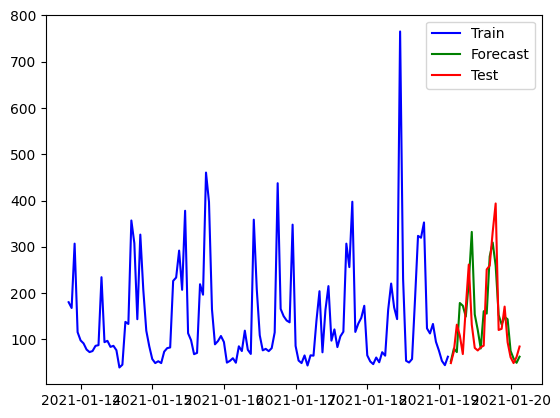

MSE  6362.531537865678
MAE  55.63718729272201


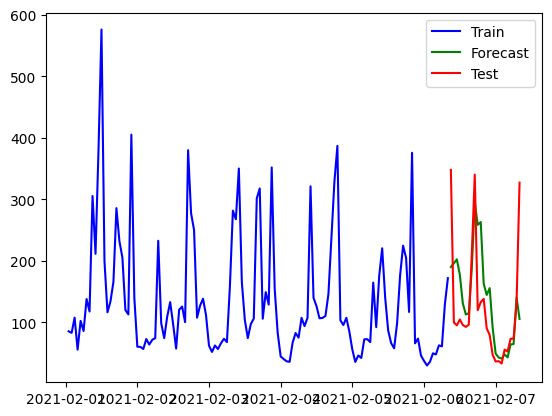

MSE  4650.075174665003
MAE  44.93643046682123


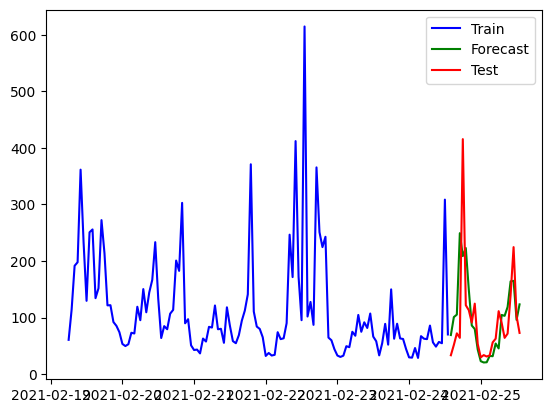

MSE  4891.594988350272
MAE  44.52406990144465


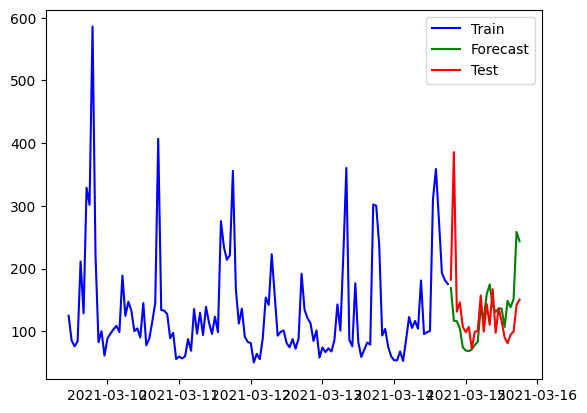

MSE  3272.1575175682574
MAE  43.37383352025385


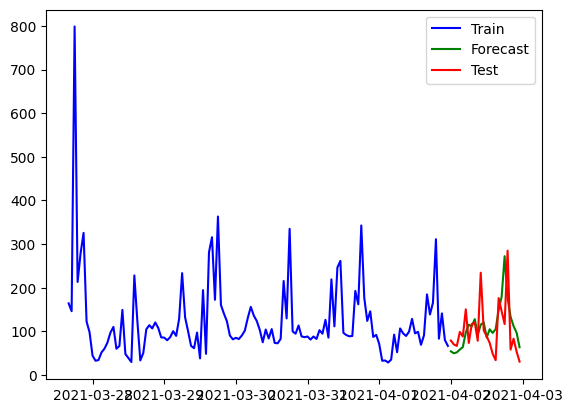

Model for: e_utilization_1
MSE  50940.20184546595
MAE  184.71117598246448


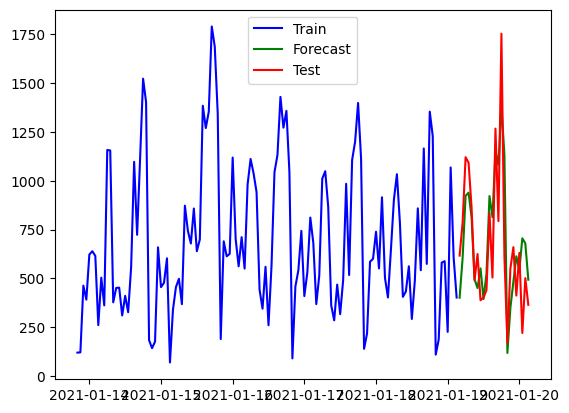

MSE  40531.98436788924
MAE  160.31934189366808


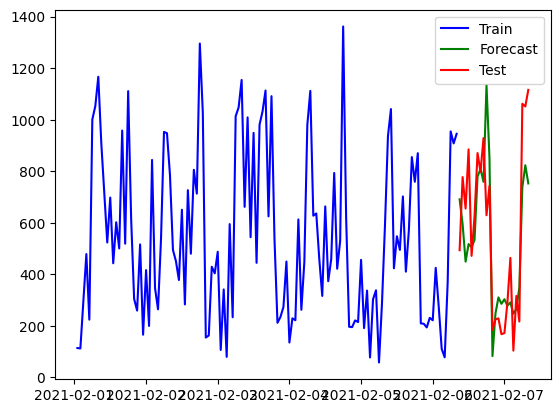

MSE  76642.98521714719
MAE  221.38040758286596


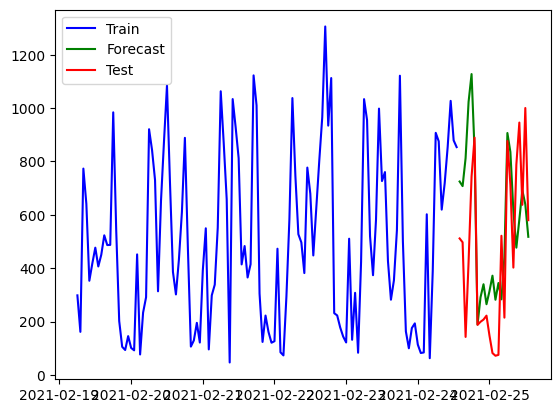

MSE  34927.39279491421
MAE  140.26655234666455


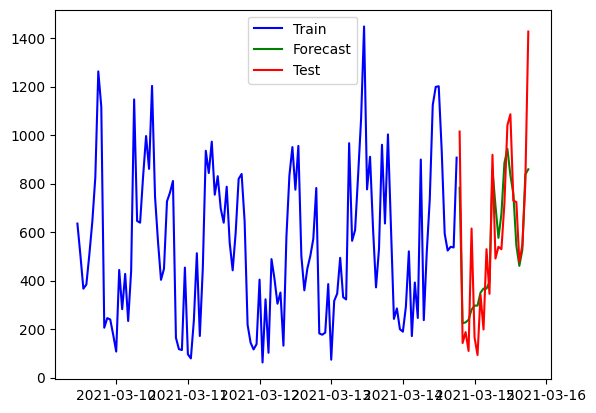

MSE  14919.644756263047
MAE  93.85391080355294


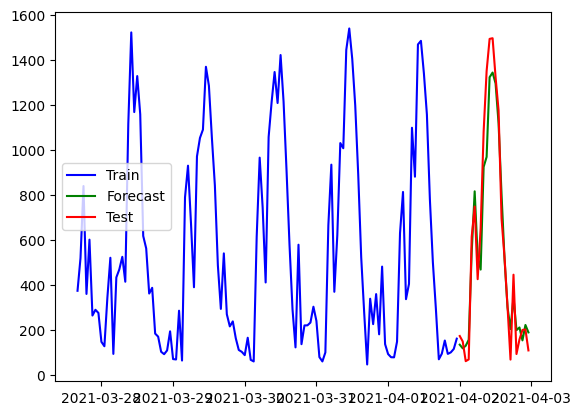

Model for: e_utilization_2
MSE  27709.212327780686
MAE  124.13751842781558


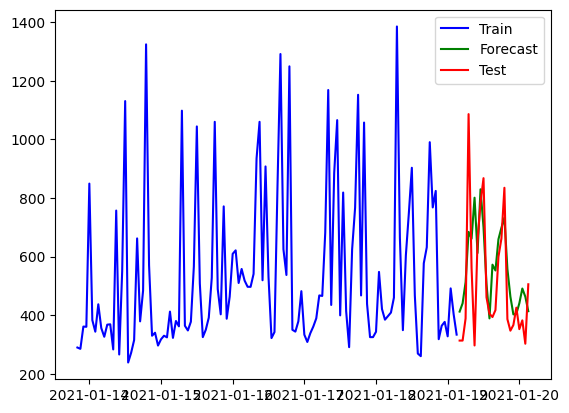

MSE  46714.28330915313
MAE  162.63515842467942


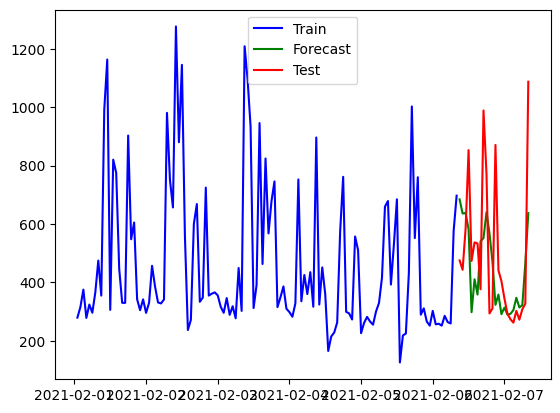

MSE  102857.61734879504
MAE  229.03491932994447


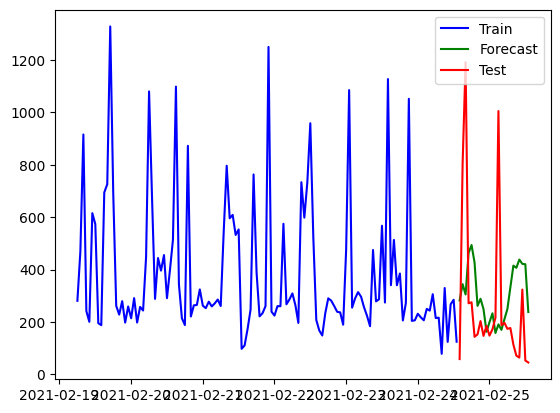

MSE  39139.34727464237
MAE  127.1999548664118


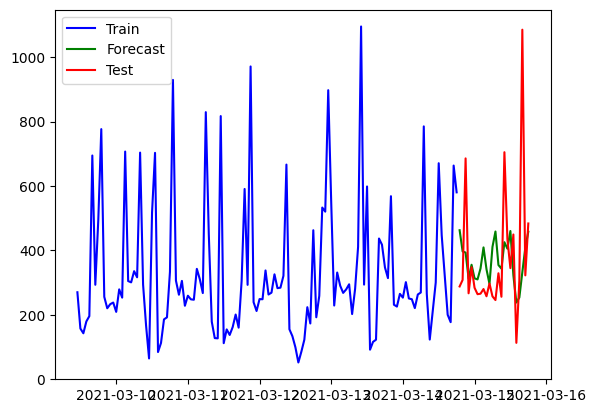

MSE  25338.61523792433
MAE  124.16863674913759


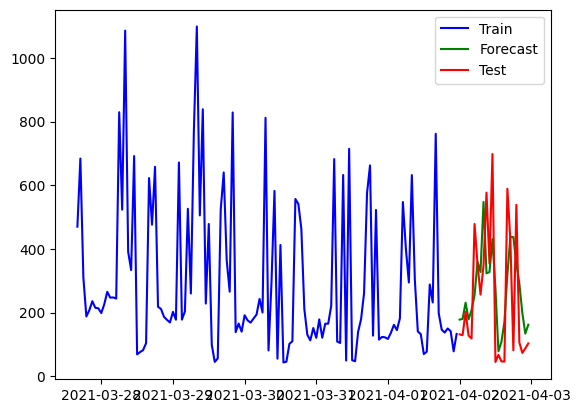

Model for: e_utilization_3
MSE  296653.0000814407
MAE  428.925269535323


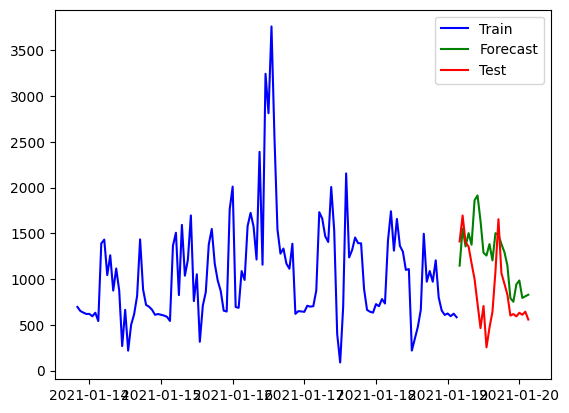

MSE  78211.77853395423
MAE  237.78144552482618


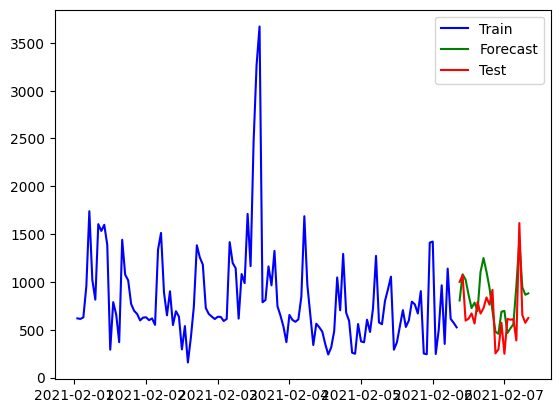

MSE  453927.94875437603
MAE  421.5701951031271


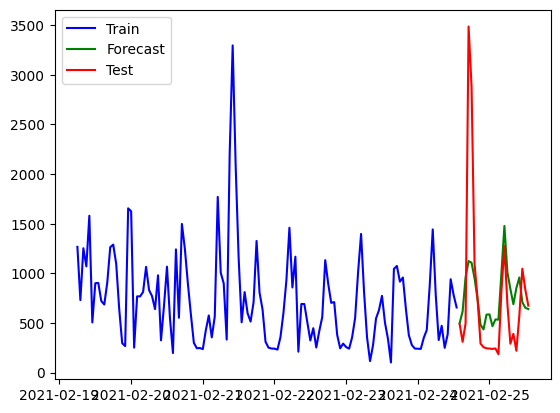

MSE  33645.5419012696
MAE  145.1663652642236


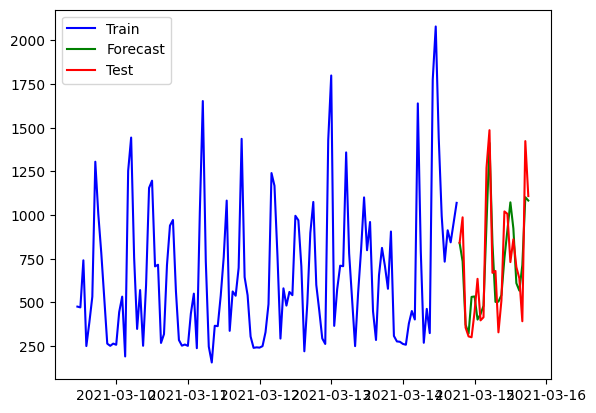

MSE  57222.44646467528
MAE  172.0525041305813


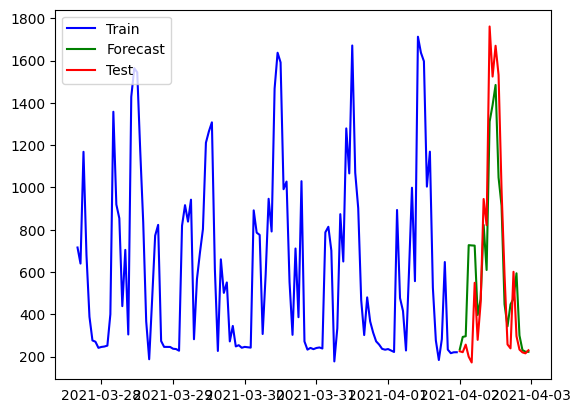

Model for: e_utilization_4
MSE  11382.248349437725
MAE  68.8982229860658


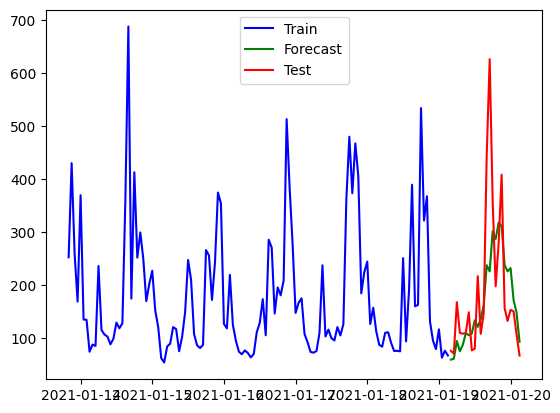

MSE  10836.84133315175
MAE  65.3300446198214


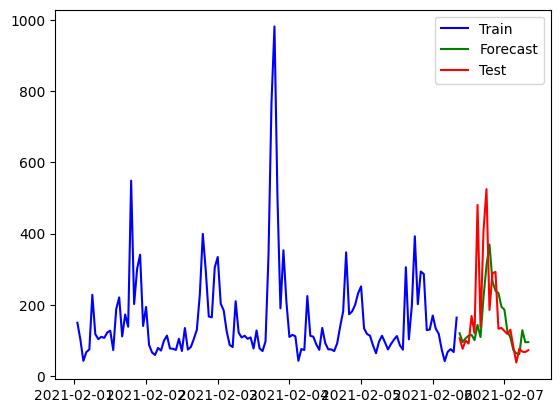

MSE  6224.095978110357
MAE  52.21539013687353


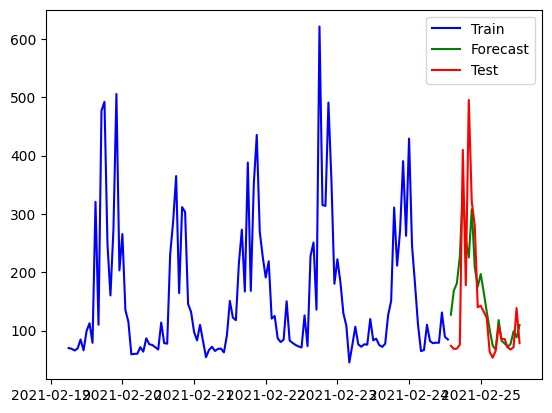

MSE  5974.3029754701965
MAE  56.35412331843715


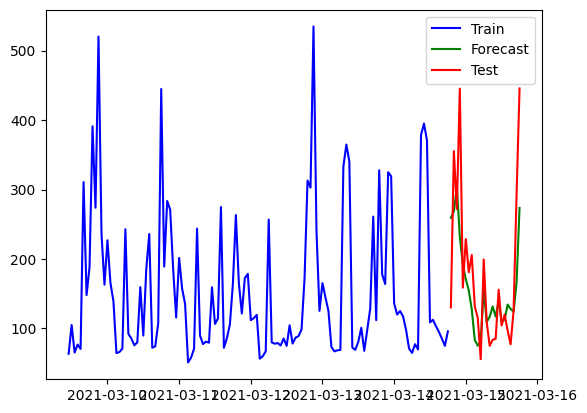

MSE  2719.604799781612
MAE  39.15341337383583


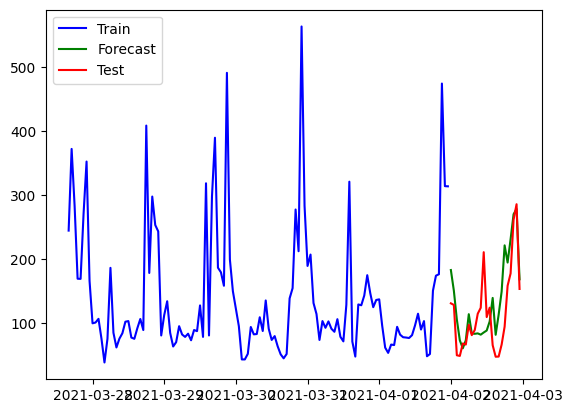

Model for: e_utilization_5
MSE  184342.10461374617
MAE  351.4770173544786


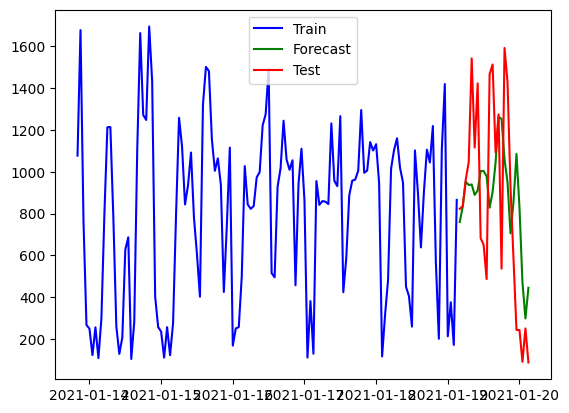

MSE  625731.6355943909
MAE  540.225031637353


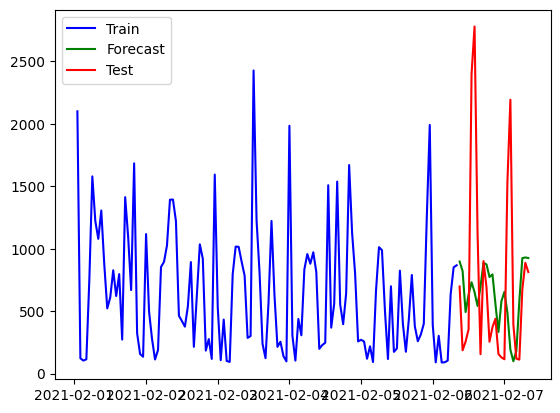

MSE  379333.4428298481
MAE  473.18514159035993


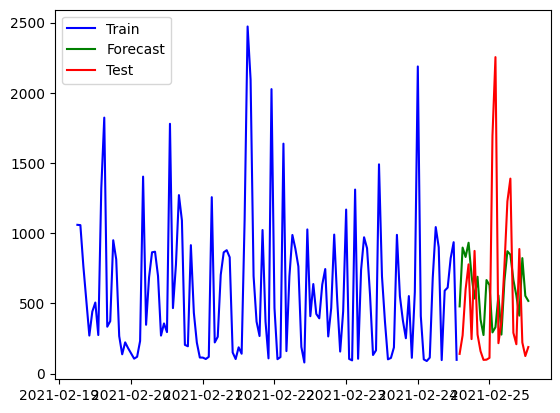

MSE  131799.85159721939
MAE  280.3475415106128


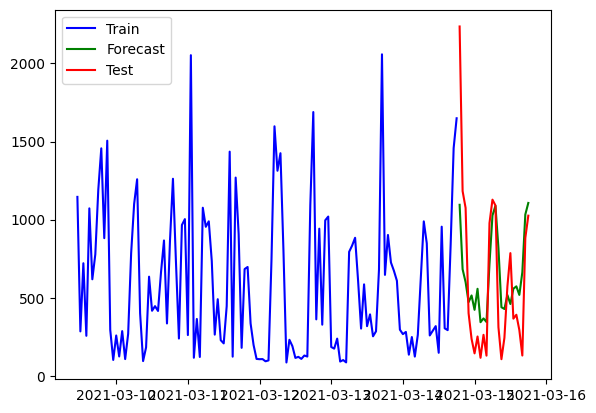

MSE  109917.57396387904
MAE  244.69448531260096


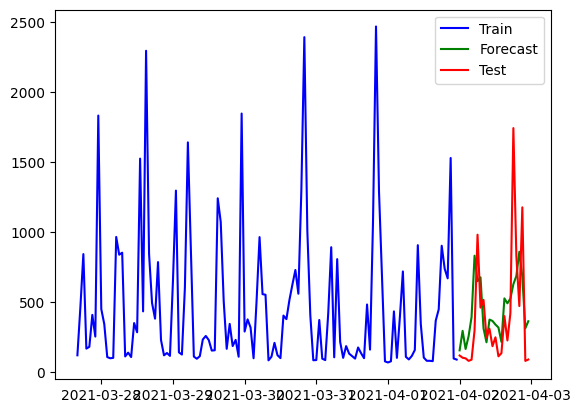

Model for: e_utilization_6
MSE  52266.361776999234
MAE  201.11843367058842


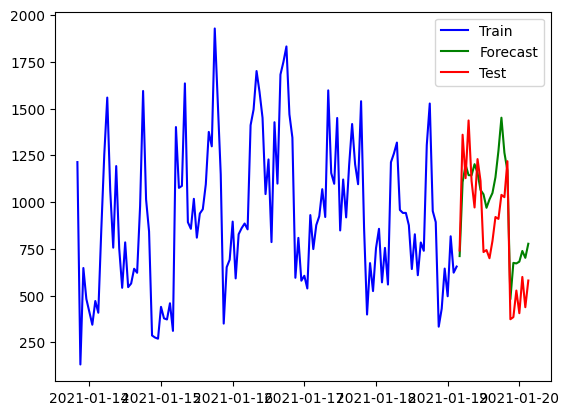

MSE  59590.15339164425
MAE  171.09105516540754


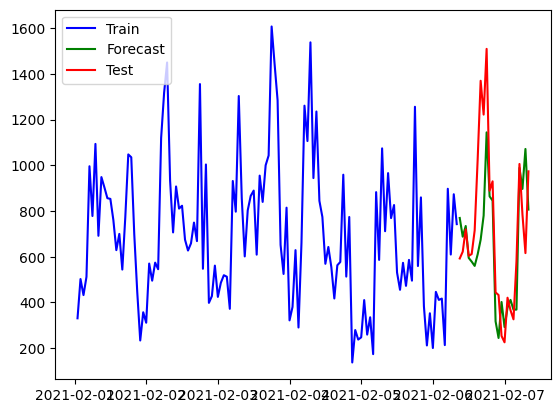

MSE  51255.68861563856
MAE  165.3244440682815


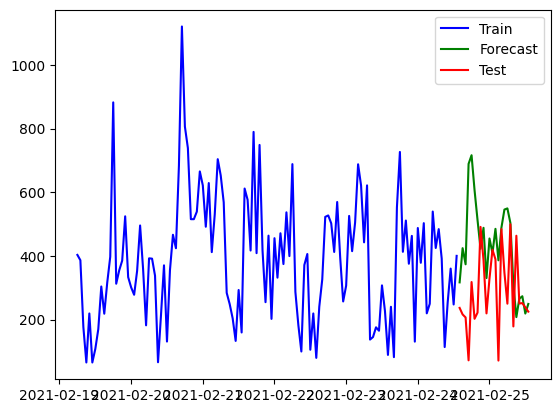

MSE  33719.69243768725
MAE  152.49338823815143


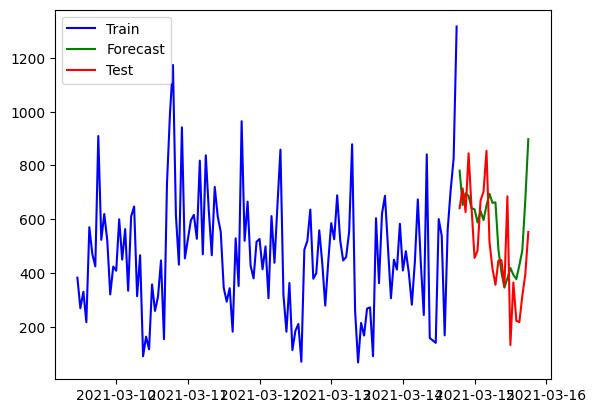

MSE  12833.39752632004
MAE  87.82948008452668


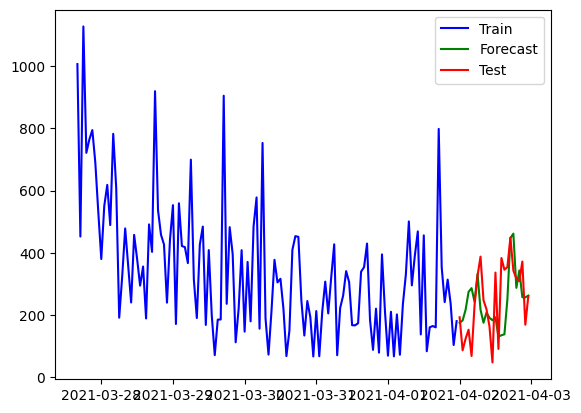

Model for: e_utilization_7
MSE  2185.0846925562596
MAE  36.829796884228124


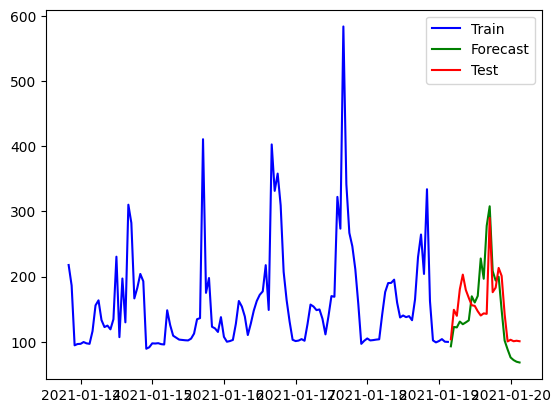

MSE  20095.45497789166
MAE  89.9268402959554


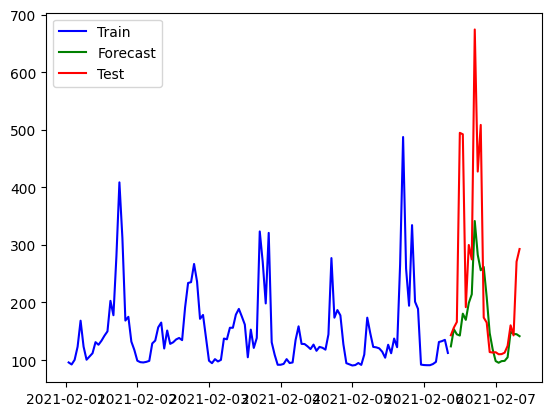

MSE  2897.860726348314
MAE  41.65806680140897


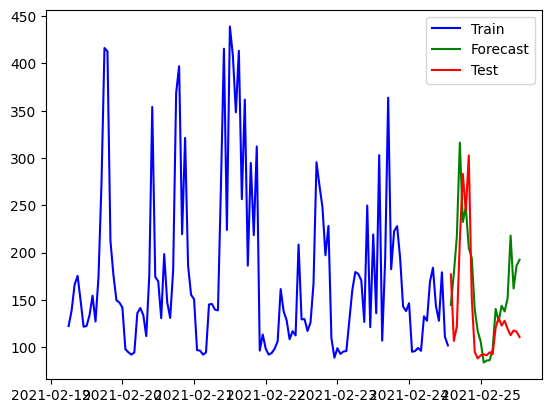

MSE  5804.81602166659
MAE  51.96151772411969


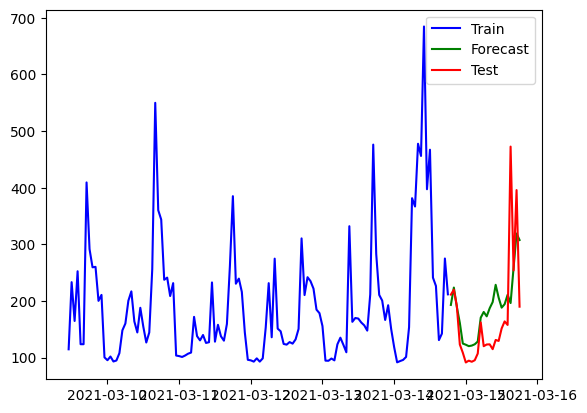

MSE  3615.6077054846196
MAE  44.53949458835595


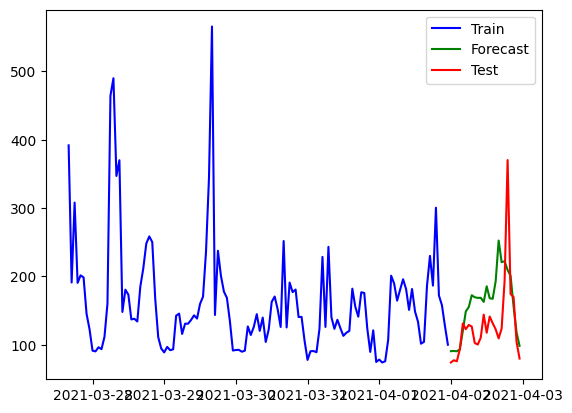

Model for: e_utilization_8
MSE  6875.799834026805
MAE  55.732763024179555


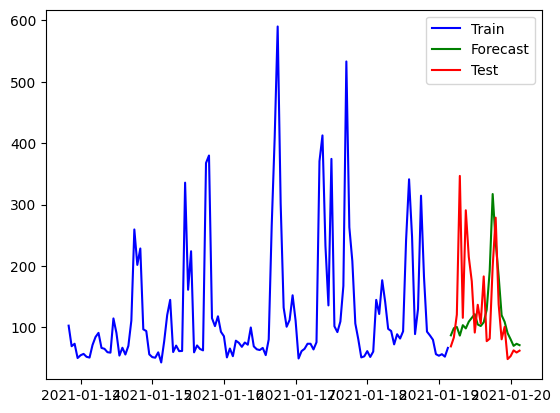

MSE  2519.7786740400566
MAE  35.986042839545746


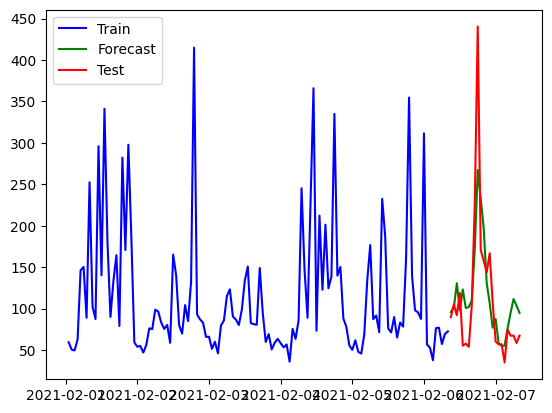

MSE  3015.521158668074
MAE  40.97921620872872


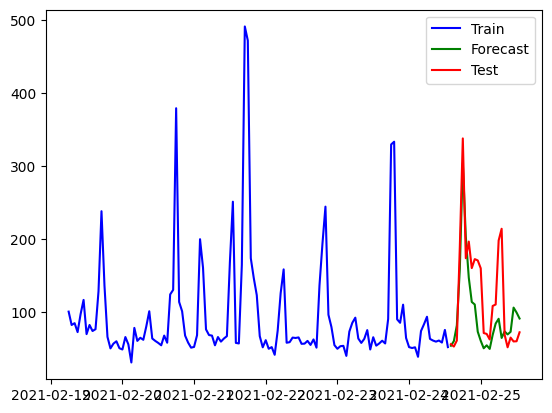

MSE  5060.765917929548
MAE  48.43110579881003


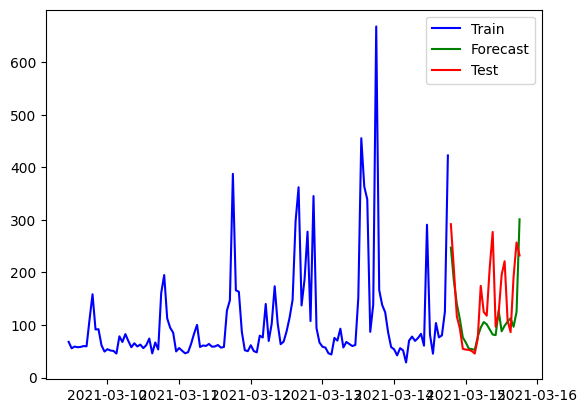

MSE  6040.938458569104
MAE  45.34280637179436


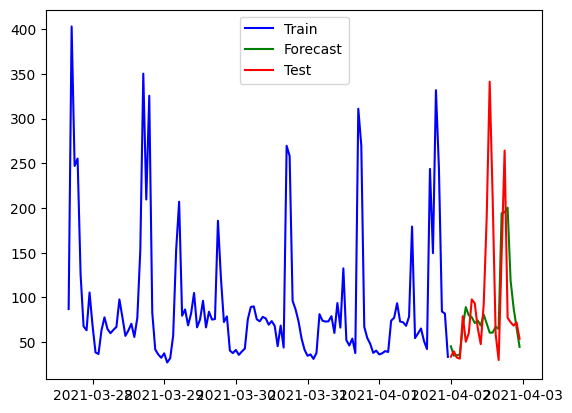

Model for: e_utilization_9
MSE  13701.635544907627
MAE  79.90468000952798


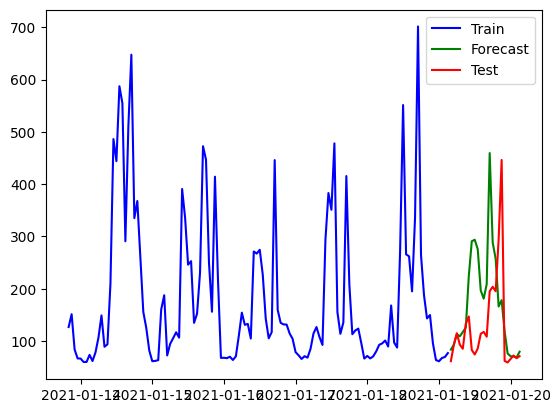

MSE  26732.905988153372
MAE  120.56878169183337


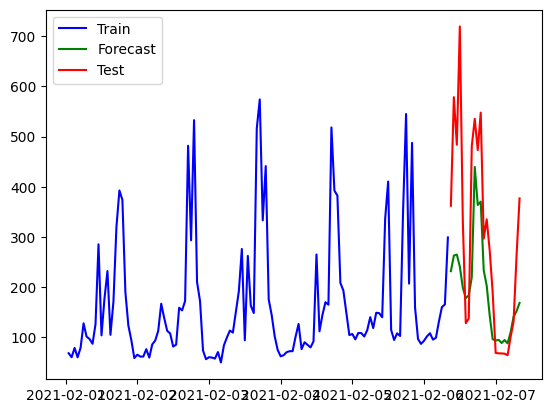

MSE  5377.7634412599955
MAE  46.76675678409274


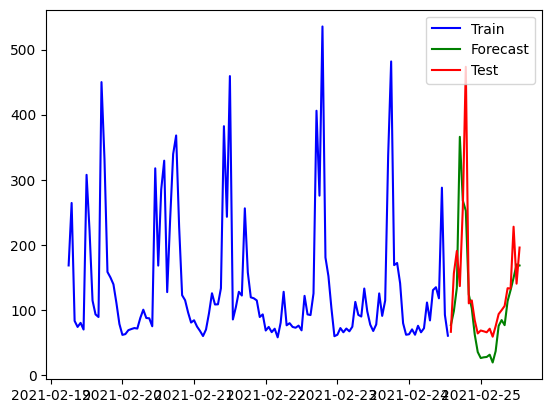

MSE  13637.873285877822
MAE  80.17205469382304


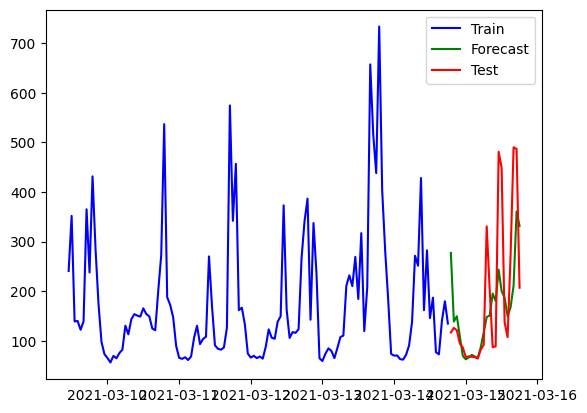

MSE  11388.083096532517
MAE  63.14859971400178


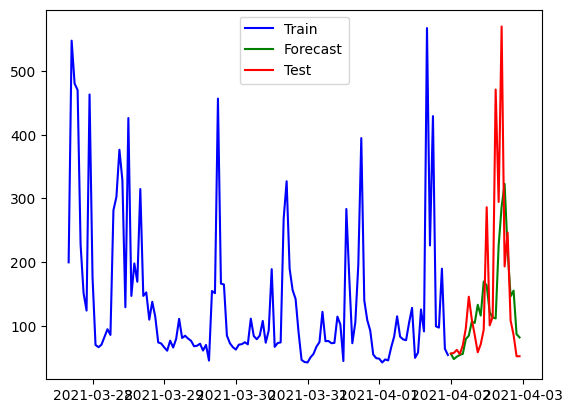

Model for: e_utilization_10
MSE  82297.98666650562
MAE  223.4218426867777


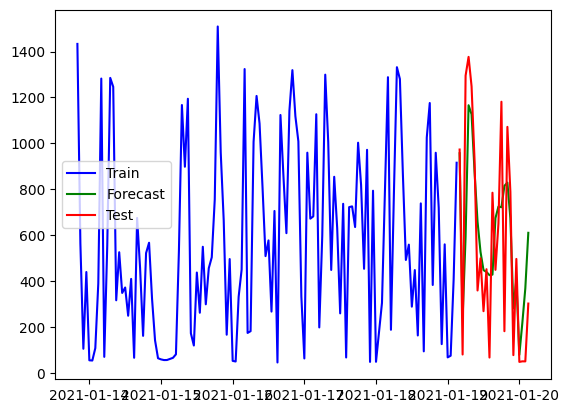

MSE  142681.4773160281
MAE  309.6966705335751


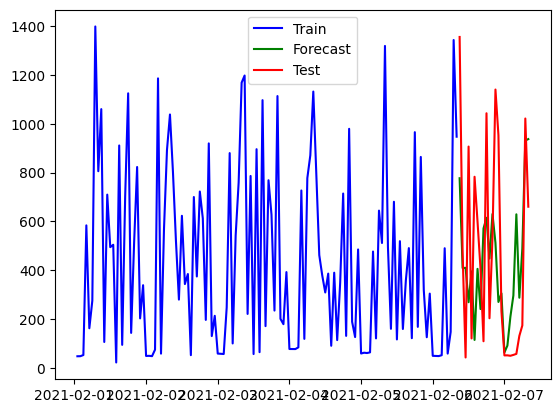

MSE  49503.75434747067
MAE  180.49725470269254


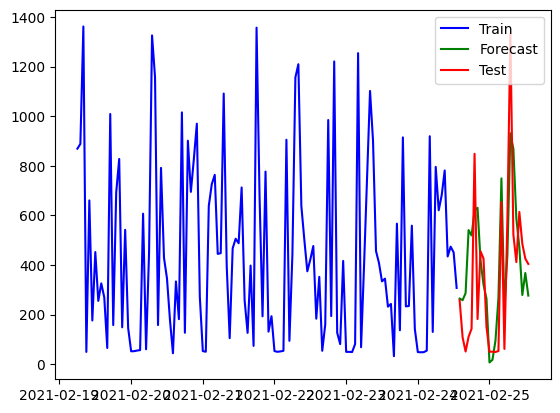

MSE  94697.43968495876
MAE  216.09275940898866


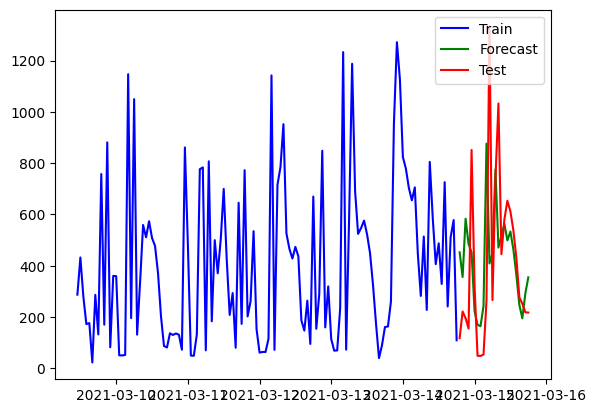

MSE  31303.129951680403
MAE  122.9585077185979


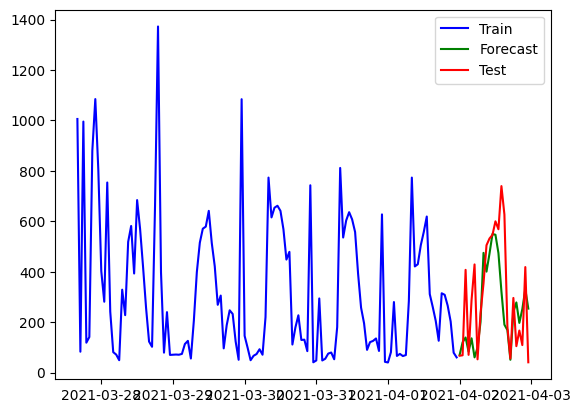

Model for: e_utilization_11
MSE  9515582.605869599
MAE  1993.207070346196


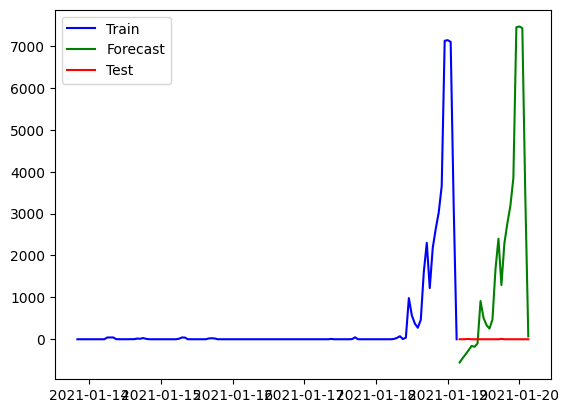

MSE  56814.80964072399
MAE  184.7115887848936


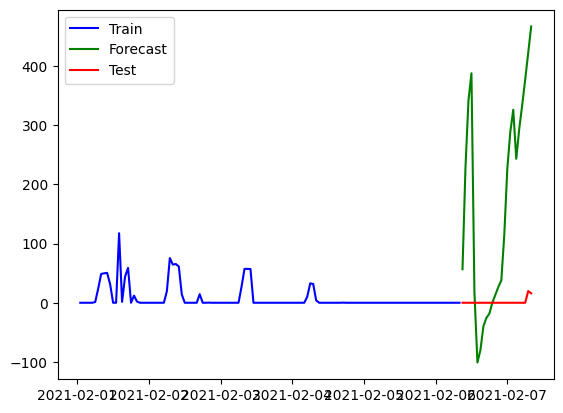

MSE  80.88437834515929
MAE  6.539663920314417


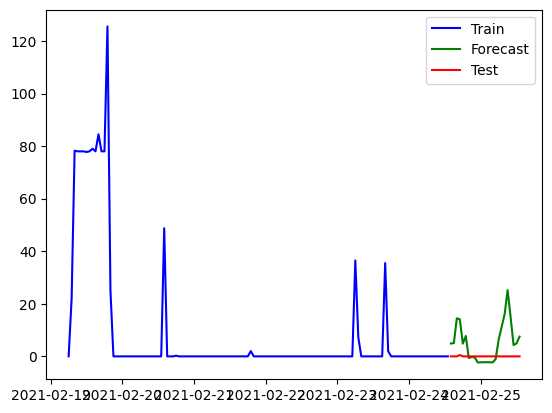

MSE  81001.25213268894
MAE  232.28374237995138


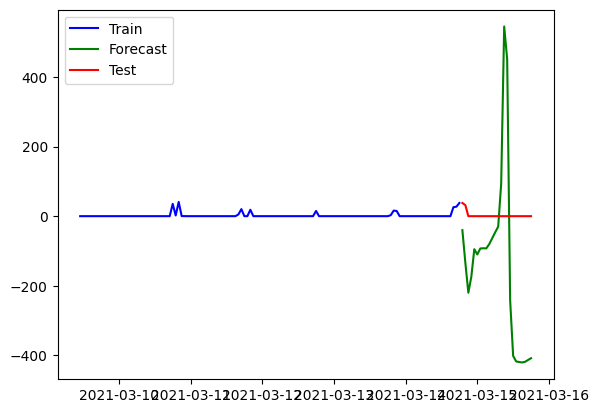

MSE  10.069792850859328
MAE  1.9765970658451755


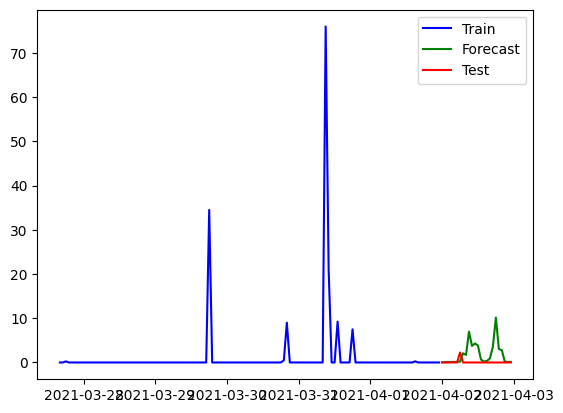

Model for: e_utilization_12
MSE  7613.553951504789
MAE  70.17879531999078


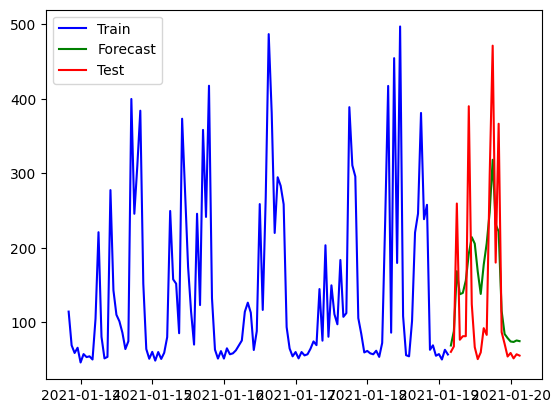

MSE  4440.628764125501
MAE  43.224778308999596


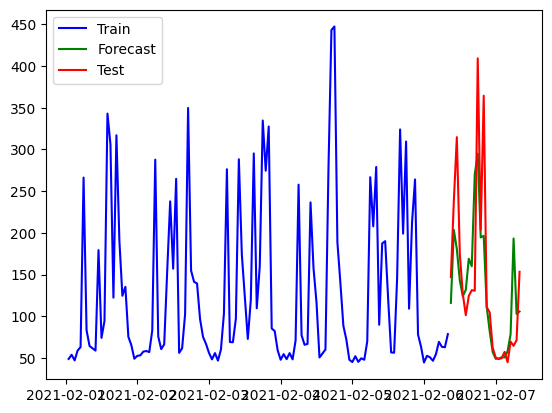

MSE  6161.244083342865
MAE  55.33903301891502


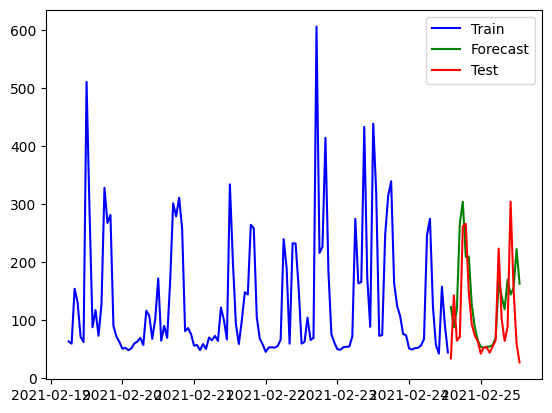

MSE  14776.869938415866
MAE  71.21989682240445


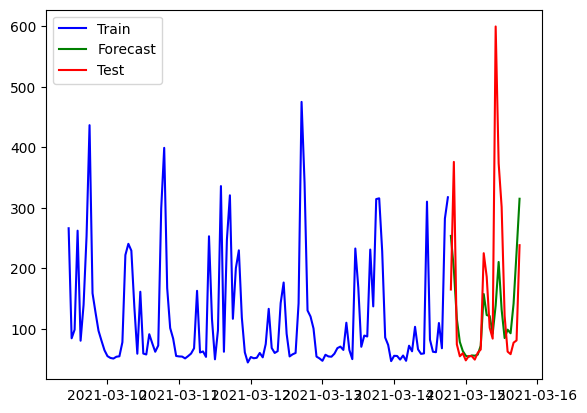

MSE  3192.932595904982
MAE  40.570597542815165


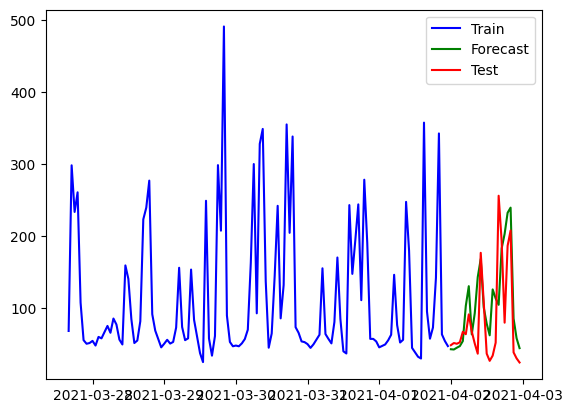

Model for: e_utilization_13
MSE  742349.1618066978
MAE  692.8588292780267


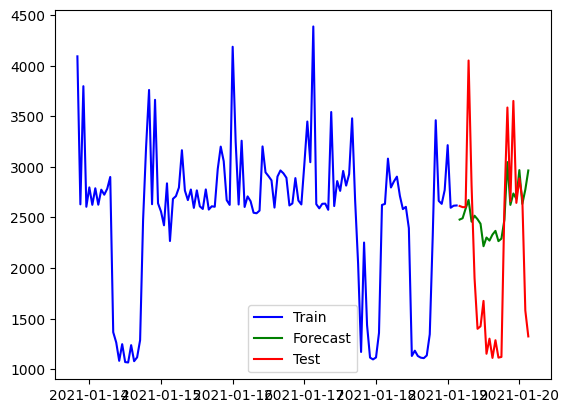

MSE  187639.96760590267
MAE  365.79227772423354


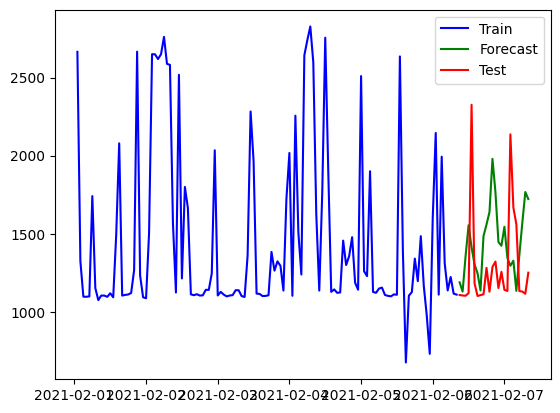

MSE  315276.55877744005
MAE  489.2583486395967


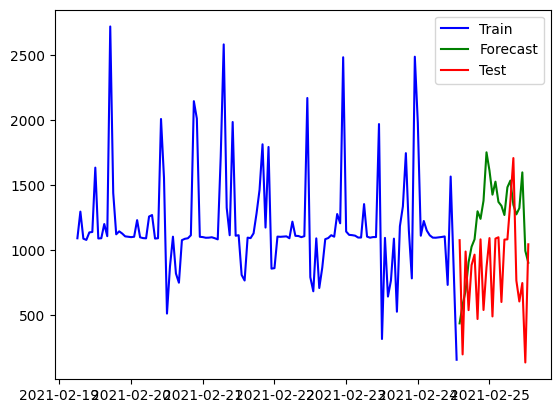

MSE  146001.90288091687
MAE  297.51299639418727


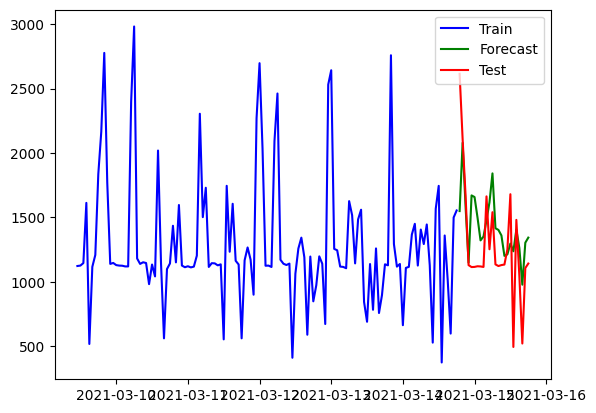

MSE  151721.31654802876
MAE  313.67174826184157


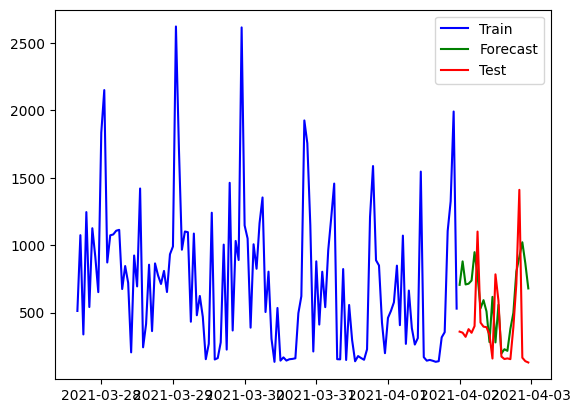

Model for: e_utilization_14
MSE  35870.24446423129
MAE  147.02667385069273


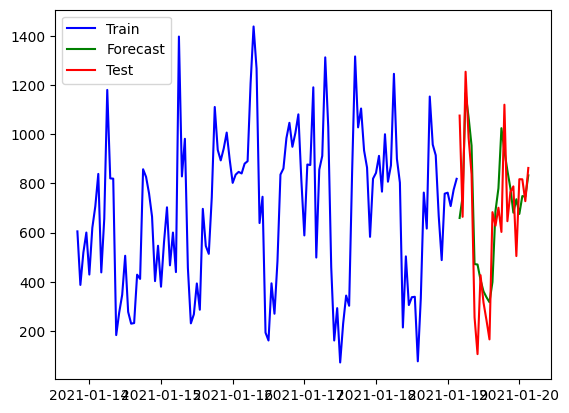

MSE  21352.855145118923
MAE  121.37061423721762


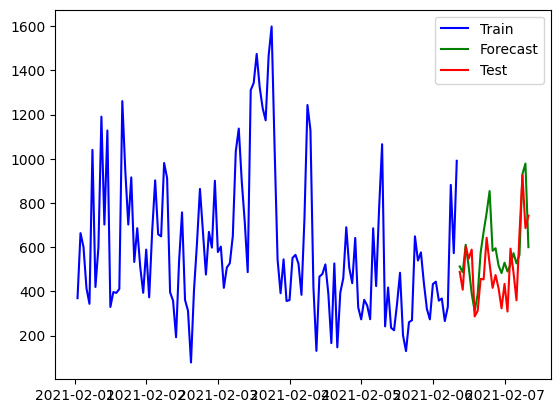

MSE  62698.6832081615
MAE  221.93341861186147


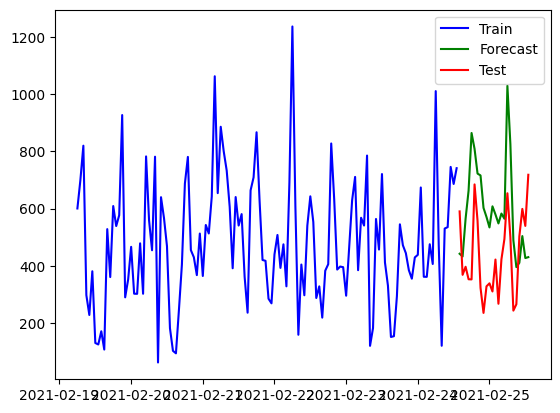

MSE  28968.27589958512
MAE  156.53943236583493


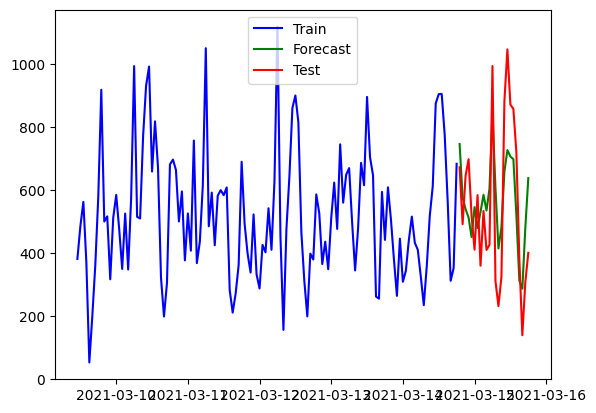

MSE  21690.723722989987
MAE  127.23585111897171


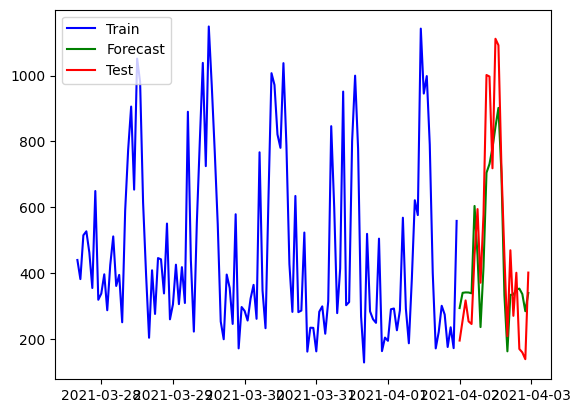

Model for: e_utilization_15
MSE  17650.337913380252
MAE  107.73039348986272


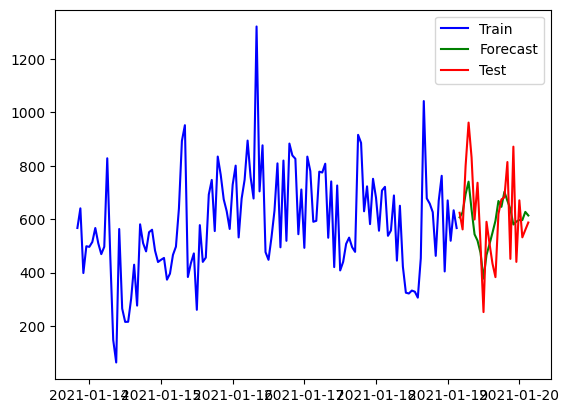

MSE  14926.322238076658
MAE  93.52895626031723


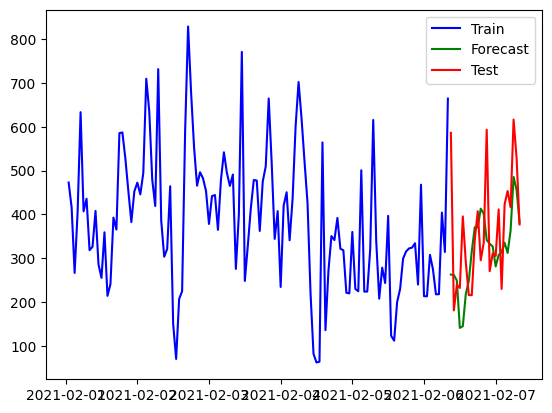

MSE  21053.299688096577
MAE  129.8824307977119


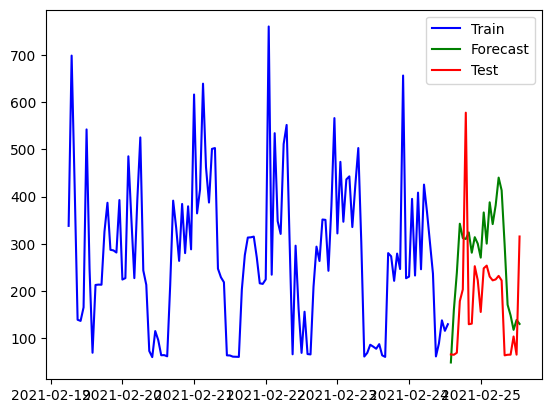

MSE  19643.598929989555
MAE  117.13537487201442


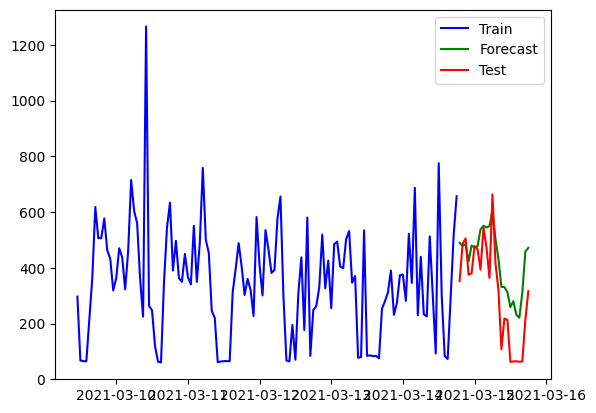

MSE  9240.689841816973
MAE  76.31401109056237


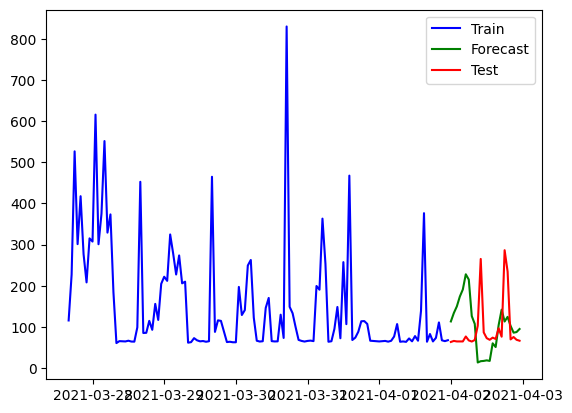

Model for: e_utilization_16
MSE  140898.42032208215
MAE  311.6371043203042


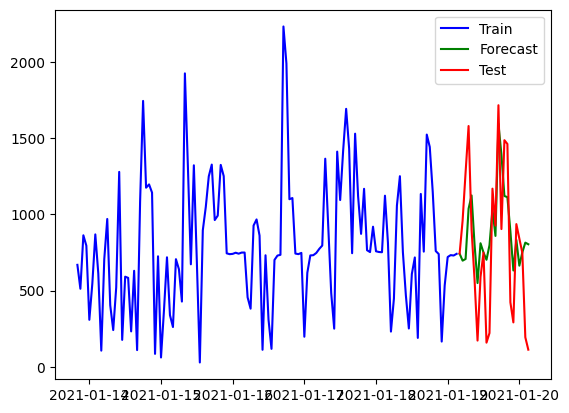

MSE  93841.10636286791
MAE  267.68737071998


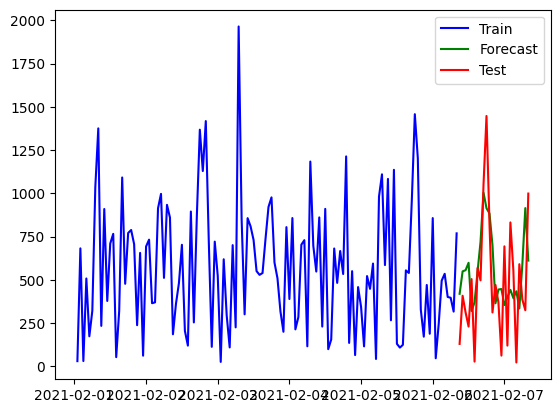

MSE  112964.75736091989
MAE  279.0715647119977


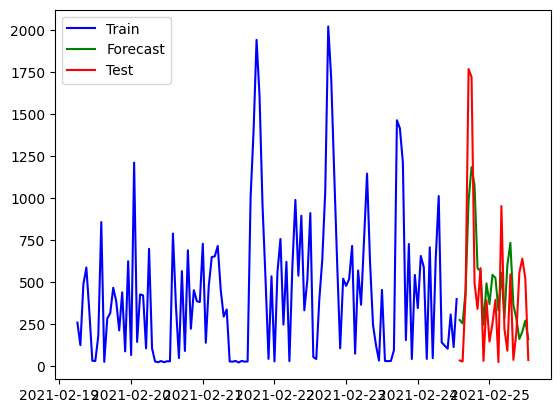

MSE  145624.4480955853
MAE  323.8821776896461


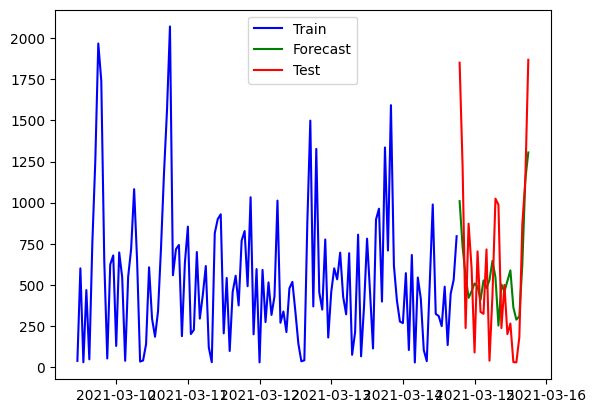

MSE  87382.03795187421
MAE  228.77905734466708


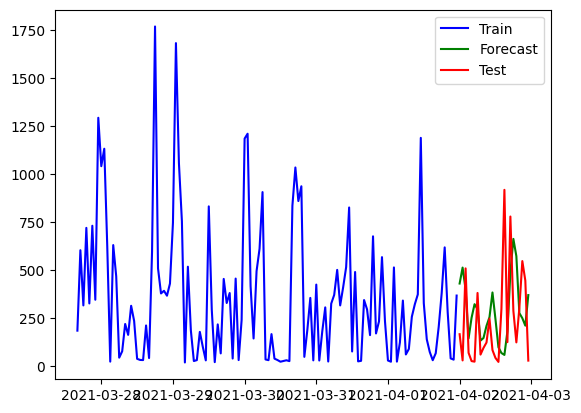

Model for: e_utilization_17
MSE  30100.942527009134
MAE  140.70776668120826


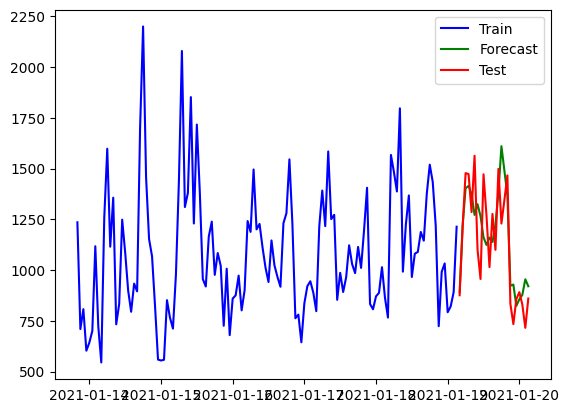

MSE  51012.09278177208
MAE  172.46971271953157


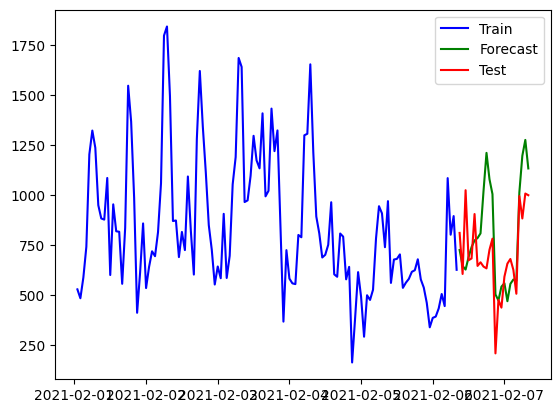

MSE  111580.76565452723
MAE  308.5708244960666


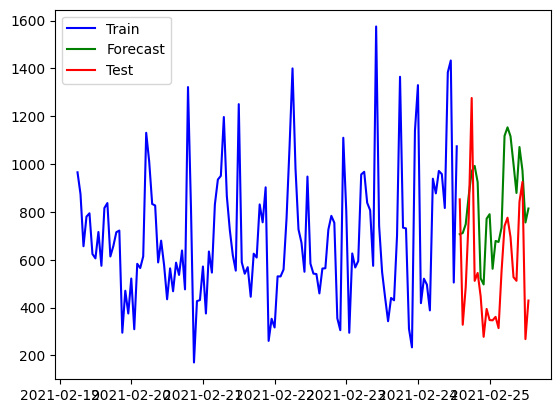

MSE  63847.648546765326
MAE  210.36085438187797


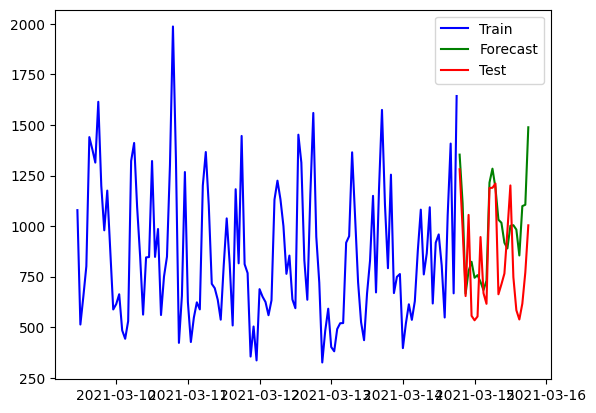

MSE  122720.34948083751
MAE  323.6895606910138


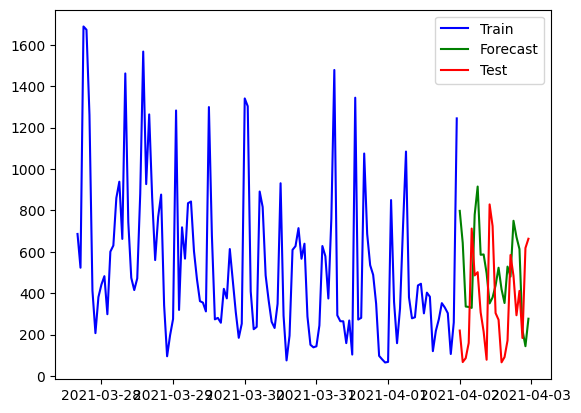

Model for: e_utilization_18
MSE  62570.69376670901
MAE  185.92141929664558


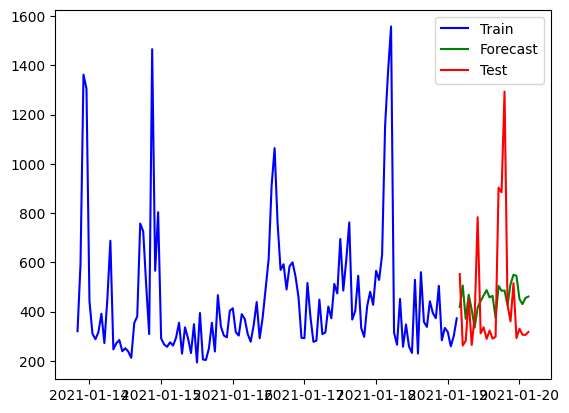

MSE  139631.08264076753
MAE  250.69819210512392


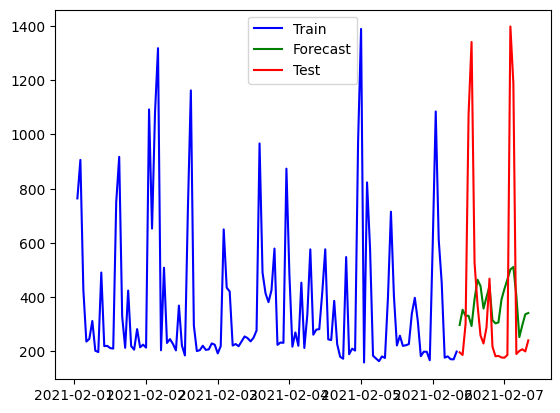

MSE  172288.2854612469
MAE  306.67623433628006


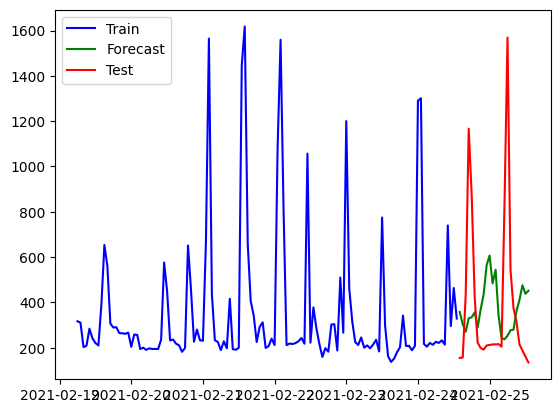

MSE  28002.50139963544
MAE  131.16217549307316


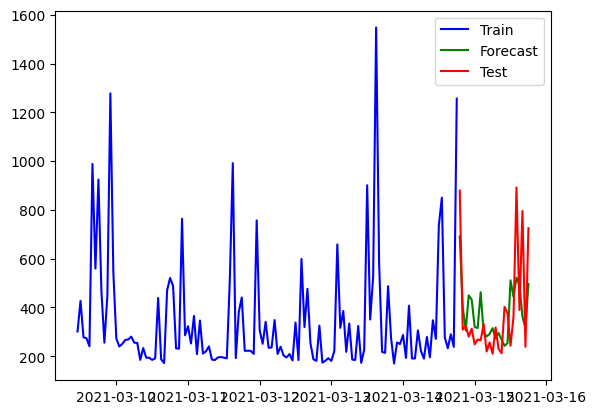

MSE  113501.62199424811
MAE  210.88036422303654


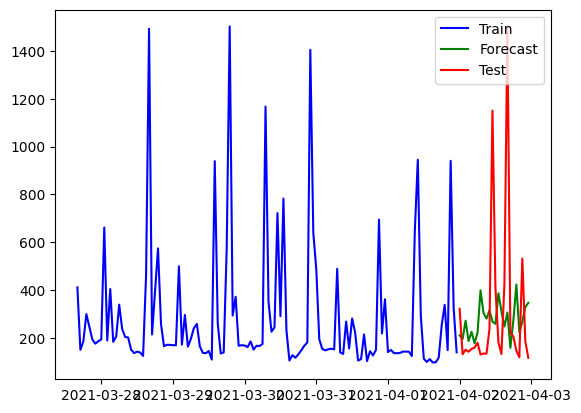

Model for: e_utilization_19
MSE  558900.3415804433
MAE  538.46535590223


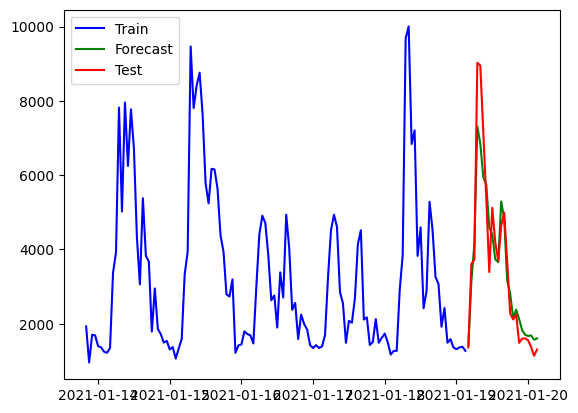

MSE  909735.2219053094
MAE  586.74562478907


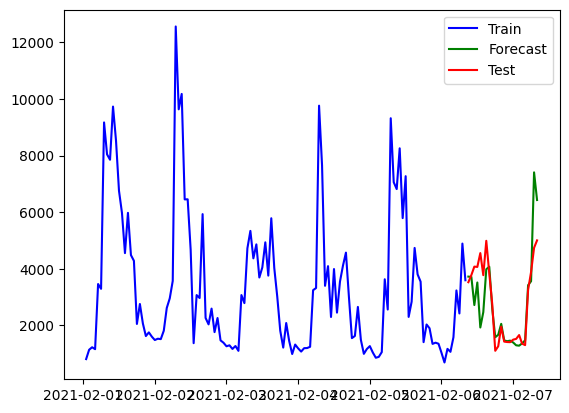

MSE  1486658.1722710358
MAE  724.9812710904752


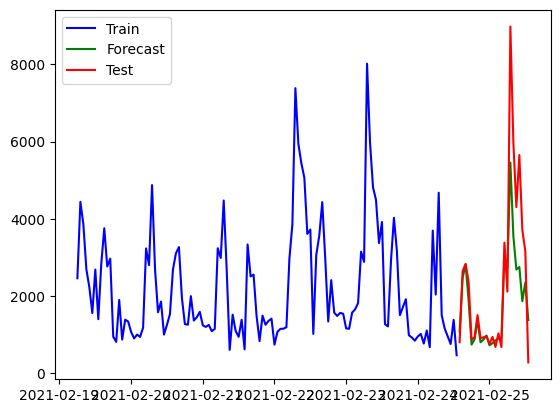

MSE  494964.71938059543
MAE  480.11197891864686


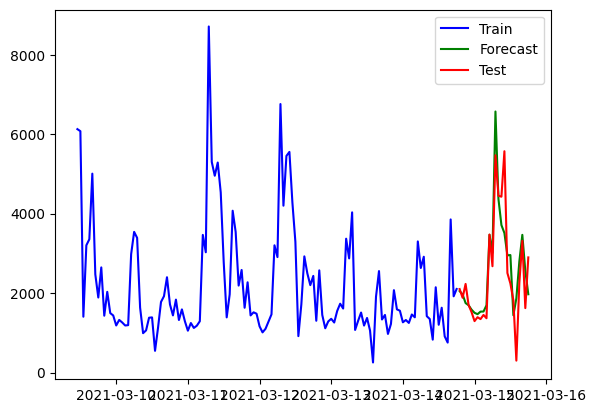

MSE  1311862.8652626416
MAE  789.7902488029799


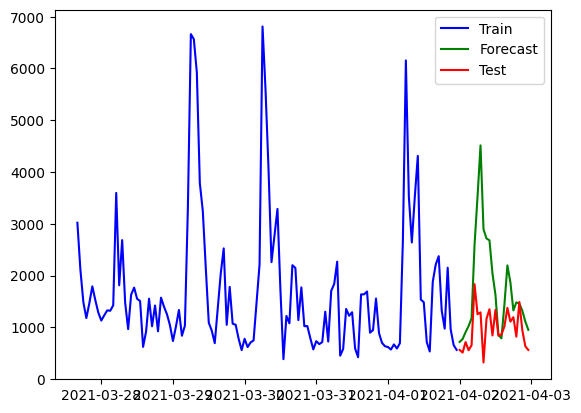

Model for: e_utilization_battery
MSE  0.010347746512965354
MAE  0.094701720426974


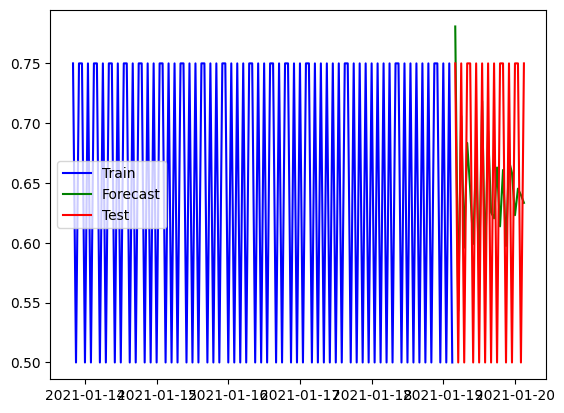

MSE  1265.3446720948202
MAE  31.62369757093741


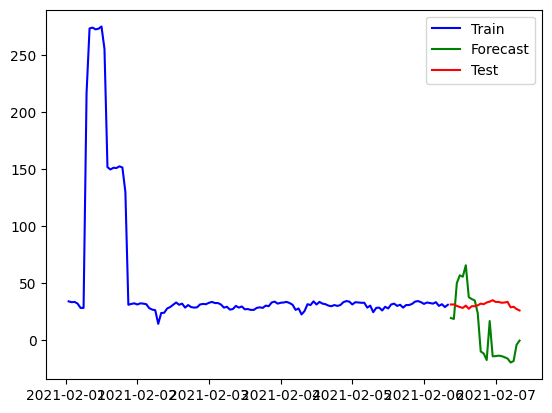

MSE  6.459043201645137
MAE  2.306179009988817


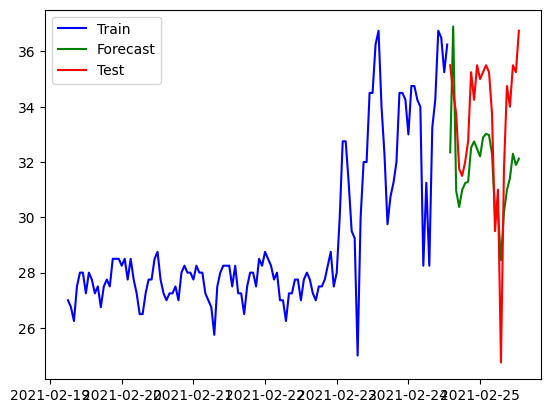

MSE  4379.959175144904
MAE  14.36622376403774


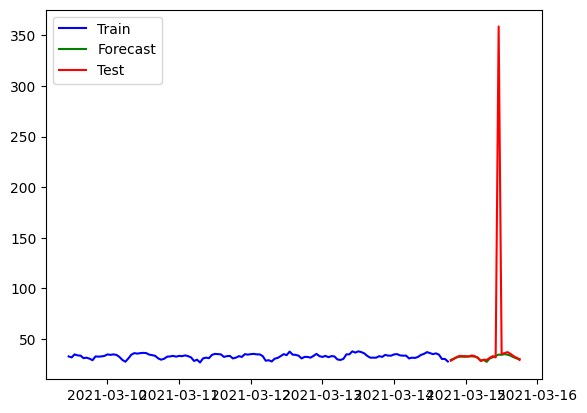

MSE  3.604618134658826
MAE  1.5742381088013133


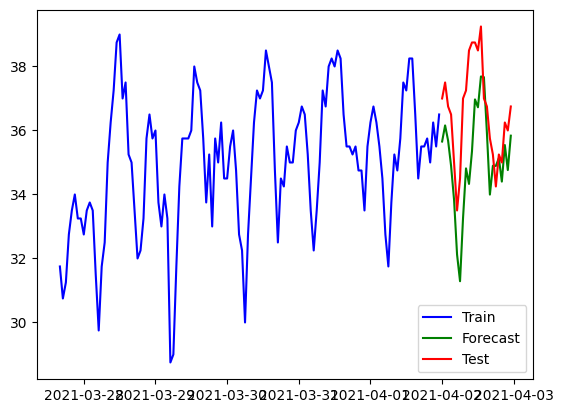

Model for: e_utilization_PCC
MSE  10052469.556029037
MAE  2686.753680899709


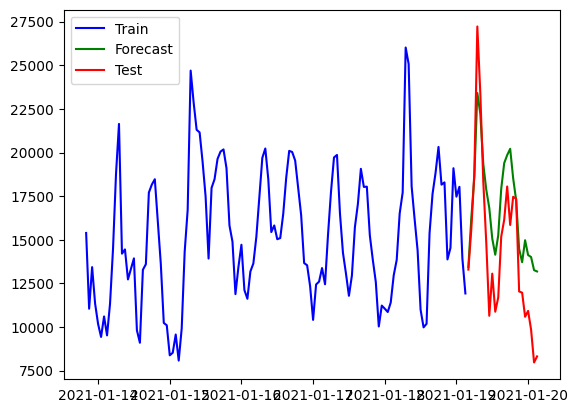

MSE  8901804.092101015
MAE  2203.52060621549


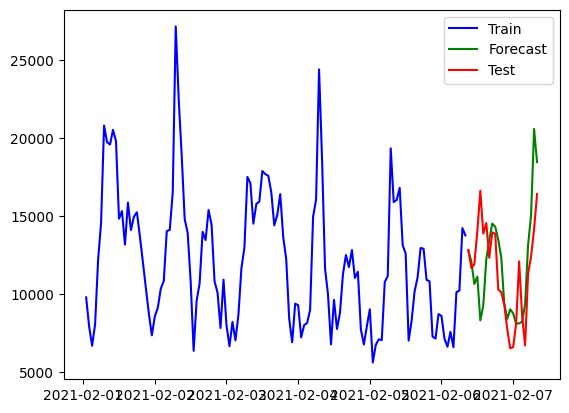

MSE  2753018.0968308626
MAE  1359.5921268512493


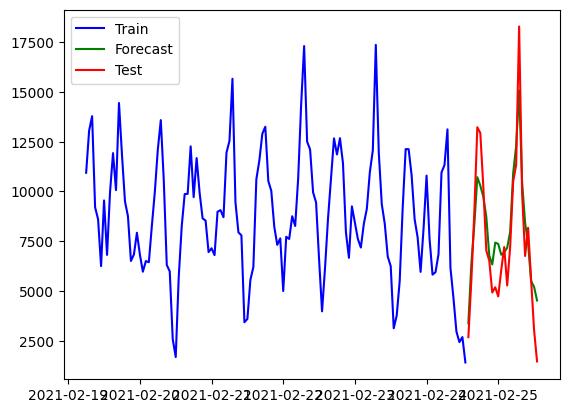

MSE  3297614.8387970403
MAE  1589.2187760619727


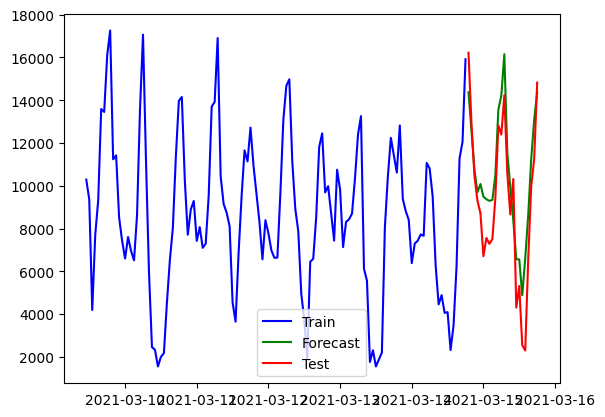

MSE  5246035.525774572
MAE  1914.466060730588


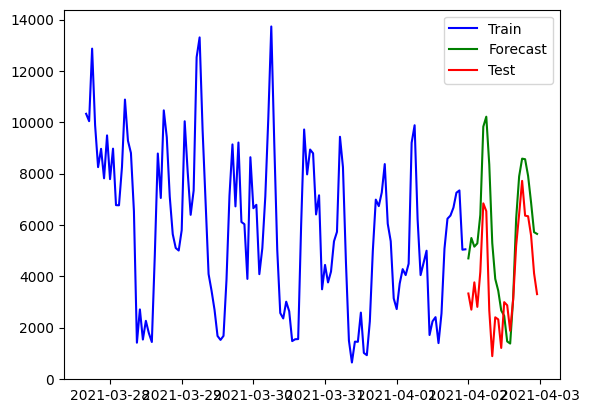

In [60]:
losses_mae_columns = []
losses_mse_columns = []

for cl in pdf_meters.columns:
    print("Model for: " + cl)
    train, test = model_selection.train_test_split(pdf_meters[cl], test_size=24)
    
    arma = pm.ARIMA(order=(1, 0, 1),
                    seasonal_order=(0, 1, 1, 24), # choose 24 for daily seasonality, seen in auto regressive plots
                    suppress_warnings=True)
    

    window_size = np.floor(len(train) / 40) # making the window a bit shorter to save time 
    step = np.floor(len(train) / 40)
    cv = model_selection.SlidingWindowForecastCV(window_size=int(window_size), step=int(step), h=24) 
    splitter_cv = cv.split(train)

    losses_mae = []
    losses_mse = []

    for i in range(5): # 5 folds 
        tr_idx, te_idx = next(splitter_cv)
        x_tr = train[tr_idx]
        y_tr = train[te_idx]


        arma.fit(x_tr)
        pred = arma.predict(len(y_tr))
        mse = mean_squared_error(y_tr, pred)
        mae = mean_absolute_error(y_tr, pred)
        losses_mae.append(mae)
        losses_mse.append(mse)
        print("MSE ", mse)
        print("MAE ", mae)

        plt.plot(x_tr[-128:], c='blue', label="Train")
        plt.plot(pred[:24], c="green", label="Forecast")
        plt.plot(y_tr[:24], c="red", label="Test")
        plt.legend()
        plt.show()
    
    losses_mae_columns.append(losses_mae)
    losses_mse_columns.append(losses_mse)

The plots indicate that the model is generally capable of making accurate forecasts.

In [61]:
mae_errors = pd.DataFrame(np.array(losses_mae_columns).T, columns=pdf_meters.columns)
mse_errors = pd.DataFrame(np.array(losses_mse_columns).T, columns=pdf_meters.columns)

In [ ]:
fig = px.line(mae_errors, title='MAE')
fig

In [ ]:
fig = px.line(mse_errors, title='MSE')
fig

In [64]:
mae_errors.describe()

e_utilization_0  e_utilization_1  e_utilization_2  e_utilization_3  \
count         5.000000         5.000000         5.000000         5.000000   
mean         47.192453       160.106278       153.435238       281.099156   
std           4.954651        47.809403        45.285568       135.858375   
min          43.373834        93.853911       124.137518       145.166365   
25%          44.524070       140.266552       124.168637       172.052504   
50%          44.936430       160.319342       127.199955       237.781446   
75%          47.490743       184.711176       162.635158       421.570195   
max          55.637187       221.380408       229.034919       428.925270   

       e_utilization_4  e_utilization_5  e_utilization_6  e_utilization_7  \
count         5.000000         5.000000         5.000000         5.000000   
mean         56.390239       377.985843       155.571360        52.983143   
std          11.735721       125.883878        41.859753        21.367988   
min          39.153413       244.694485        87.829480        36.829797   
25%          52.215390       280.347542       152.493388        41.658067   
50%          56.354123       351.477017       165.324444        44.539495   
75%          65.330045       473.185142       171.091055        51.961518   
max          68.898223       540.225032       201.118434        89.926840   

       e_utilization_8  e_utilization_9  ...  e_utilization_12  \
count         5.000000         5.000000  ...          5.000000   
mean         45.294387        78.112175  ...         56.106620   
std           7.484434        27.461170  ...         14.442440   
min          35.986043        46.766757  ...         40.570598   
25%          40.979216        63.148600  ...         43.224778   
50%          45.342806        79.904680  ...         55.339033   
75%          48.431106        80.172055  ...         70.178795   
max          55.732763       120.568782  ...         71.219897   

       e_utilization_13  e_utilization_14  e_utilization_15  e_utilization_16  \
count          5.000000          5.000000          5.000000          5.000000   
mean         431.818840        154.821198        104.918233        282.211455   
std          164.162629         40.148630         20.786384         37.676740   
min          297.512996        121.370614         76.314011        228.779057   
25%          313.671748        127.235851         93.528956        267.687371   
50%          365.792278        147.026674        107.730393        279.071565   
75%          489.258349        156.539432        117.135375        311.637104   
max          692.858829        221.933419        129.882431        323.882178   

       e_utilization_17  e_utilization_18  e_utilization_19  \
count          5.000000          5.000000          5.000000   
mean         231.159744        217.067677        624.018896   
std           81.567328         66.236003        129.510085   
min          140.707767        131.162175        480.111979   
25%          172.469713        185.921419        538.465356   
50%          210.360854        210.880364        586.745625   
75%          308.570824        250.698192        724.981271   
max          323.689561        306.676234        789.790249   

       e_utilization_battery  e_utilization_PCC  
count               5.000000           5.000000  
mean                9.993008        1950.710250  
std                13.369286         521.316452  
min                 0.094702        1359.592127  
25%                 1.574238        1589.218776  
50%                 2.306179        1914.466061  
75%                14.366224        2203.520606  
max                31.623698        2686.753681  

[8 rows x 22 columns]

In [65]:
mse_errors.describe()

e_utilization_0  e_utilization_1  e_utilization_2  e_utilization_3  \
count         5.000000         5.000000         5.000000         5.000000   
mean       4728.275079     43592.441796     48351.815100    183932.143147   
std        1106.025135     22654.507069     31678.691457    183998.595018   
min        3272.157518     14919.644756     25338.615238     33645.541901   
25%        4465.016174     34927.392795     27709.212328     57222.446465   
50%        4650.075175     40531.984368     39139.347275     78211.778534   
75%        4891.594988     50940.201845     46714.283309    296653.000081   
max        6362.531538     76642.985217    102857.617349    453927.948754   

       e_utilization_4  e_utilization_5  e_utilization_6  e_utilization_7  \
count         5.000000         5.000000         5.000000         5.000000   
mean       7427.418687    286224.921720     41933.058750      6919.764825   
std        3639.638816    217511.779592     18839.527859      7489.196964   
min        2719.604800    109917.573964     12833.397526      2185.084693   
25%        5974.302975    131799.851597     33719.692438      2897.860726   
50%        6224.095978    184342.104614     51255.688616      3615.607705   
75%       10836.841333    379333.442830     52266.361777      5804.816022   
max       11382.248349    625731.635594     59590.153392     20095.454978   

       e_utilization_8  e_utilization_9  ...  e_utilization_12  \
count         5.000000         5.000000  ...          5.000000   
mean       4702.560809     14167.652271  ...       7237.045867   
std        1887.668809      7800.185715  ...       4536.597172   
min        2519.778674      5377.763441  ...       3192.932596   
25%        3015.521159     11388.083097  ...       4440.628764   
50%        5060.765918     13637.873286  ...       6161.244083   
75%        6040.938459     13701.635545  ...       7613.553952   
max        6875.799834     26732.905988  ...      14776.869938   

       e_utilization_13  e_utilization_14  e_utilization_15  e_utilization_16  \
count          5.000000          5.000000          5.000000          5.000000   
mean      308597.781524      34116.156488      16502.849722     116142.154019   
std       251924.246414      17057.487897       4666.691405      26536.085043   
min       146001.902881      21352.855145       9240.689842      87382.037952   
25%       151721.316548      21690.723723      14926.322238      93841.106363   
50%       187639.967606      28968.275900      17650.337913     112964.757361   
75%       315276.558777      35870.244464      19643.598930     140898.420322   
max       742349.161807      62698.683208      21053.299688     145624.448096   

       e_utilization_17  e_utilization_18  e_utilization_19  \
count          5.000000          5.000000      5.000000e+00   
mean       75852.359798     103198.837053      9.524243e+05   
std        39772.702894      58120.441112      4.417450e+05   
min        30100.942527      28002.501400      4.949647e+05   
25%        51012.092782      62570.693767      5.589003e+05   
50%        63847.648547     113501.621994      9.097352e+05   
75%       111580.765655     139631.082641      1.311863e+06   
max       122720.349481     172288.285461      1.486658e+06   

       e_utilization_battery  e_utilization_PCC  
count               5.000000       5.000000e+00  
mean             1131.075571       6.050188e+06  
std              1896.611089       3.288032e+06  
min                 0.010348       2.753018e+06  
25%                 3.604618       3.297615e+06  
50%                 6.459043       5.246036e+06  
75%              1265.344672       8.901804e+06  
max              4379.959175       1.005247e+07  

[8 rows x 22 columns]

We see that the model has a stable performance across the different splits most of the houses.  
While for the PCC forecast struggles a bit.

## Probabilistic forecast model using LSTM and NHITS models

We defined a preprocessing function to prepare the data to be used in a NeuralForecast model, the data had to be defined in a predefined preset that included:
- ds = the datetime
- y = the target values
- unique_id = the column name in our case the house or pcc

As such we proceeded to transform the data to satisfy this preset.
We converted the datetimes to not include the timezone value.
Interpolated missing values, there is no option to drop them like previously used.


In [66]:
 #function to preprocess each column for the specific models
def preprocess_column(column_name, column_data, test_size):
    df_lstm = pd.DataFrame(column_data)

    df_lstm.rename(columns={column_name: 'y'}, inplace=True) # define target

    df_lstm.reset_index(inplace=True)
    df_lstm['ds'] = pd.to_datetime(df_lstm['index']) # move the datetimes from index to the column ds
    df_lstm.drop(columns=['index'], inplace=True)
    # transformations to ds to comply to the needed datatype
    df_lstm['ds'] = df_lstm['ds'].dt.tz_localize(None)
    df_lstm['ds'] = df_lstm['ds'].astype('datetime64[ns]')
    # assigning unique id value for the column pre-processed
    df_lstm["unique_id"] = column_name    

    # interpolate missing values
    df_lstm['y'] = df_lstm['y'].interpolate(method='linear', limit_direction='both')
    # splitting
    df_tr, df_te = model_selection.train_test_split(df_lstm, test_size=test_size)
    return df_tr, df_te

Function to create our models, this will be used for all the horizons we decided to work on, which are: 24, 12, 1.

In [67]:
def create_model(horizon, levels):
    models = [LSTM(input_size=-1, h=horizon,
                loss=MQLoss(level=levels), max_steps=1000),
            NHITS(input_size=7*horizon, h=horizon,
                    n_freq_downsample=[24, 12, 1],
                    loss=MQLoss(level=levels), max_steps=250),]
    fcst = NeuralForecast(models=models, freq="H")
    return fcst

Simple function to save computing time and actual time, it loads or save the models previously trained.

In [68]:
def save_or_load_model(model_path, fcst, df_tr):
    if os.path.exists(model_path):
        fcst = fcst.load(model_path)
    else:
        fcst.fit(df=df_tr)
        fcst.save(model_path)
    return fcst

NMAE calculator

In [75]:
nmae = lambda x,y: np.mean(np.abs(x-y))/(np.mean(x)+1e-6) # nmae used by the teacher

Print NMAE and MSE given the name of the model, training dataset, forecasts, test dataset

In [69]:
def print_measures(model, forecasts, df_tr, df_te):
  for uid in df_tr['unique_id'].unique():
      df_test = df_te.reset_index().drop("index", axis=1)
      y_te = df_test.loc[df_test['unique_id'] == uid, 'y']
      y_hat = forecasts.loc[forecasts['unique_id'] == uid, f'{model}-median']
      print(f'{uid} NMAE:{nmae(y_te.values.ravel(), y_hat.values.ravel()):0.2e}, MSE:{mean_squared_error(y_te.values.ravel(), y_hat.values.ravel()):0.2e}')


Function to plot the results, using the same values as before

In [70]:
def plot_results(model, forecasts, df_tr, df_te):
  q_names = ['lo-90','lo-80','hi-90','hi-80']

  fig, ax = plt.subplots(3, 1, figsize=(18, 12))

  plt.subplots_adjust(hspace=0.25)
  for uid, a in zip(df_tr['unique_id'].unique(), ax.ravel()):
      df_test = df_te.reset_index().drop("index", axis=1)
      y_te = df_test.loc[df_test['unique_id'] == uid, 'y']

      y_hat = forecasts.loc[forecasts['unique_id'] == uid, '{}-median'.format(model)]
      
      y_te.plot(ax=a)
      [a.plot(forecasts.loc[forecasts['unique_id'] == uid, '{}-{}'.format(model, q_str)], color='red', alpha=0.2) for q_str in q_names]
      y_hat.plot(ax=a)
      a.set_title(f'{uid} NMAE:{nmae(y_te.values.ravel(), y_hat.values.ravel()):0.2e}, MSE:{mean_squared_error(y_te.values.ravel(), y_hat.values.ravel()):0.2e}')
      a.legend()
  plt.suptitle(model)

Our first models, that have an horizon of 24

In [71]:
dfs_tr = []
dfs_te = []
for column_name in pdf_meters.columns:
    if column_name == 'unique_id':
        continue
    if column_name in ("e_utilization_3", "e_utilization_6", "e_utilization_PCC"):
        df_tr, df_te = preprocess_column(column_name, pdf_meters[column_name], 24)
        dfs_tr.append(df_tr)
        dfs_te.append(df_te)

# Concatenate all preprocessed DataFrames
df_tr = pd.concat(dfs_tr)
df_te = pd.concat(dfs_te)

Defining the model using the functions from before, in this case it will be for a 24 step model and will be saved as suck.

In [72]:
horizon = 24 # 24 steps, 1 day prediction
levels = [80, 90]
base_model_24 = create_model(horizon, levels)

model_path_24 = 'neural_forecaster_model_24'
fcst_24 = save_or_load_model(model_path_24, base_model_24, df_tr)

Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1


Using the model to forecast

In [73]:
forecasts_24 = fcst_24.predict()
forecasts_24 = forecasts_24.reset_index()
forecasts_24.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

unique_id                  ds  LSTM-median  LSTM-lo-90  LSTM-lo-80  \
0  e_utilization_3 2022-12-30 23:00:00   282.773956  161.066467  186.027100   
1  e_utilization_3 2022-12-31 00:00:00   289.977325  170.165009  201.147278   
2  e_utilization_3 2022-12-31 01:00:00   343.703979  198.073639  216.222961   
3  e_utilization_3 2022-12-31 02:00:00   462.663147  220.869690  248.692291   
4  e_utilization_3 2022-12-31 03:00:00   653.336731  290.716461  343.359375   

    LSTM-hi-80   LSTM-hi-90  NHITS-median  NHITS-lo-90  NHITS-lo-80  \
0   499.401306   596.020081    406.358551    66.181931   170.288132   
1   594.703491   738.907104    452.332458    -1.657158   136.013229   
2   662.756897   792.859436    384.678070   -60.799774    76.474426   
3   844.811401  1007.041016    332.005280   -84.681290    83.303635   
4  1069.335449  1239.787842    559.596008   114.152069   233.210083   

   NHITS-hi-80  NHITS-hi-90  
0  1020.411499  1294.074585  
1  1060.501343  1197.123535  
2   953.474060  1259.189941  
3   945.266724  1251.841919  
4  1139.683105  1387.241943

Plotting and print the results

e_utilization_3 NMAE:4.98e-01, MSE:1.87e+05
e_utilization_6 NMAE:4.55e-01, MSE:1.88e+04
e_utilization_PCC NMAE:1.81e-01, MSE:5.06e+06

e_utilization_3 NMAE:5.01e-01, MSE:1.91e+05
e_utilization_6 NMAE:4.01e-01, MSE:1.50e+04
e_utilization_PCC NMAE:1.37e-01, MSE:2.64e+06


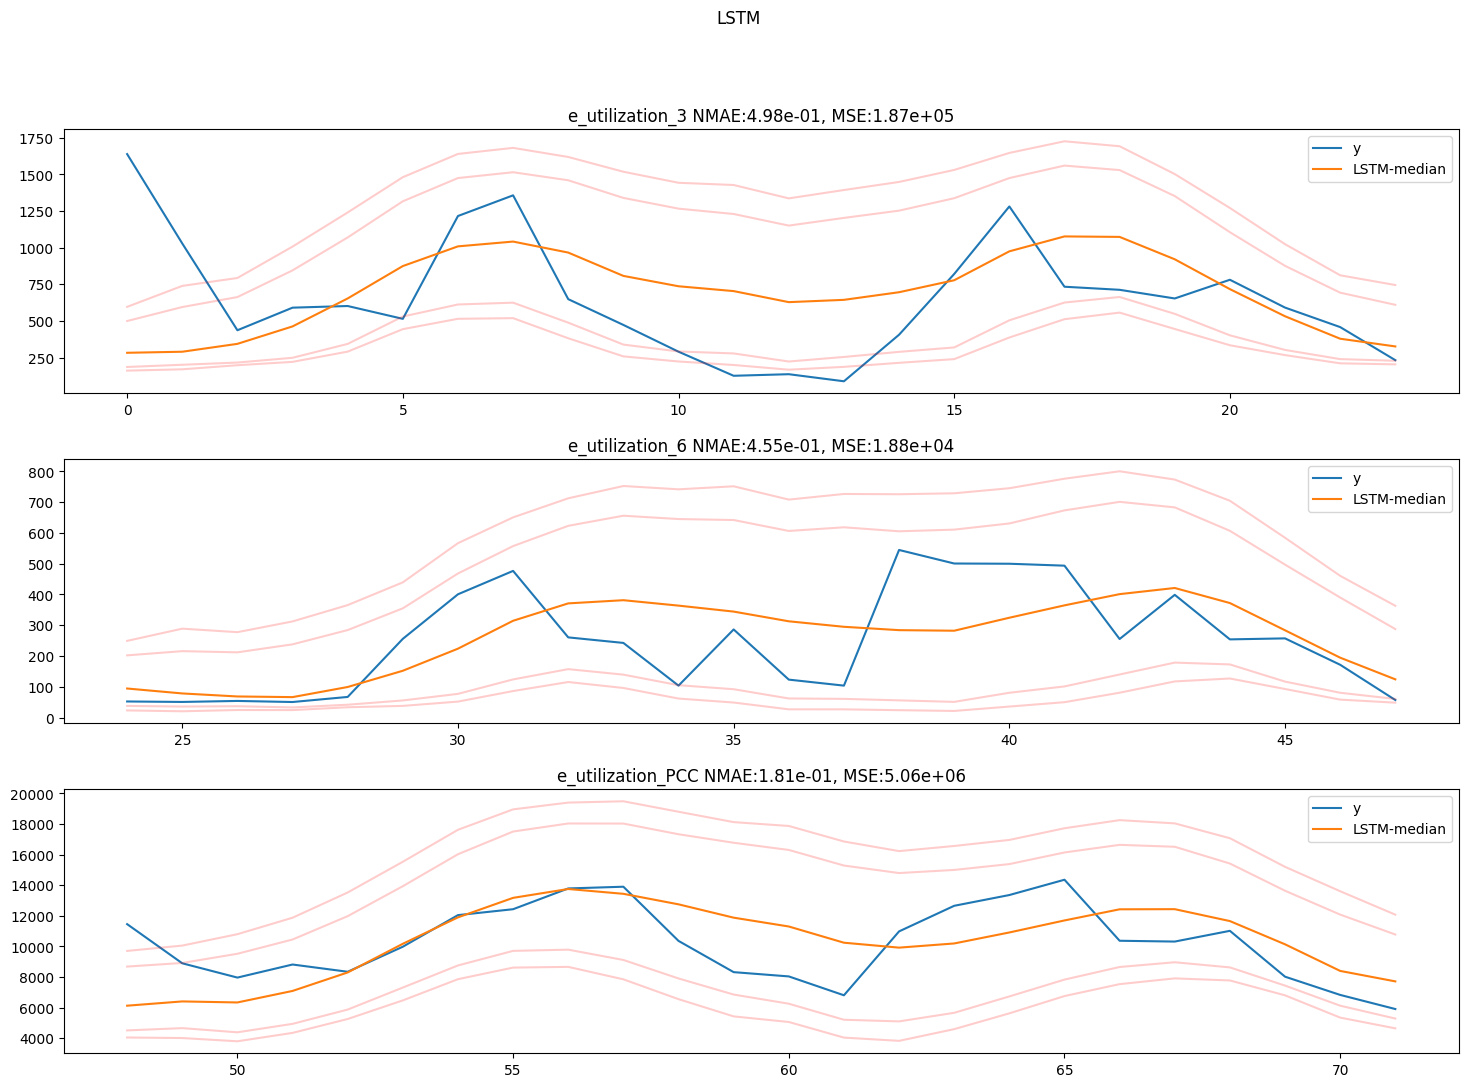

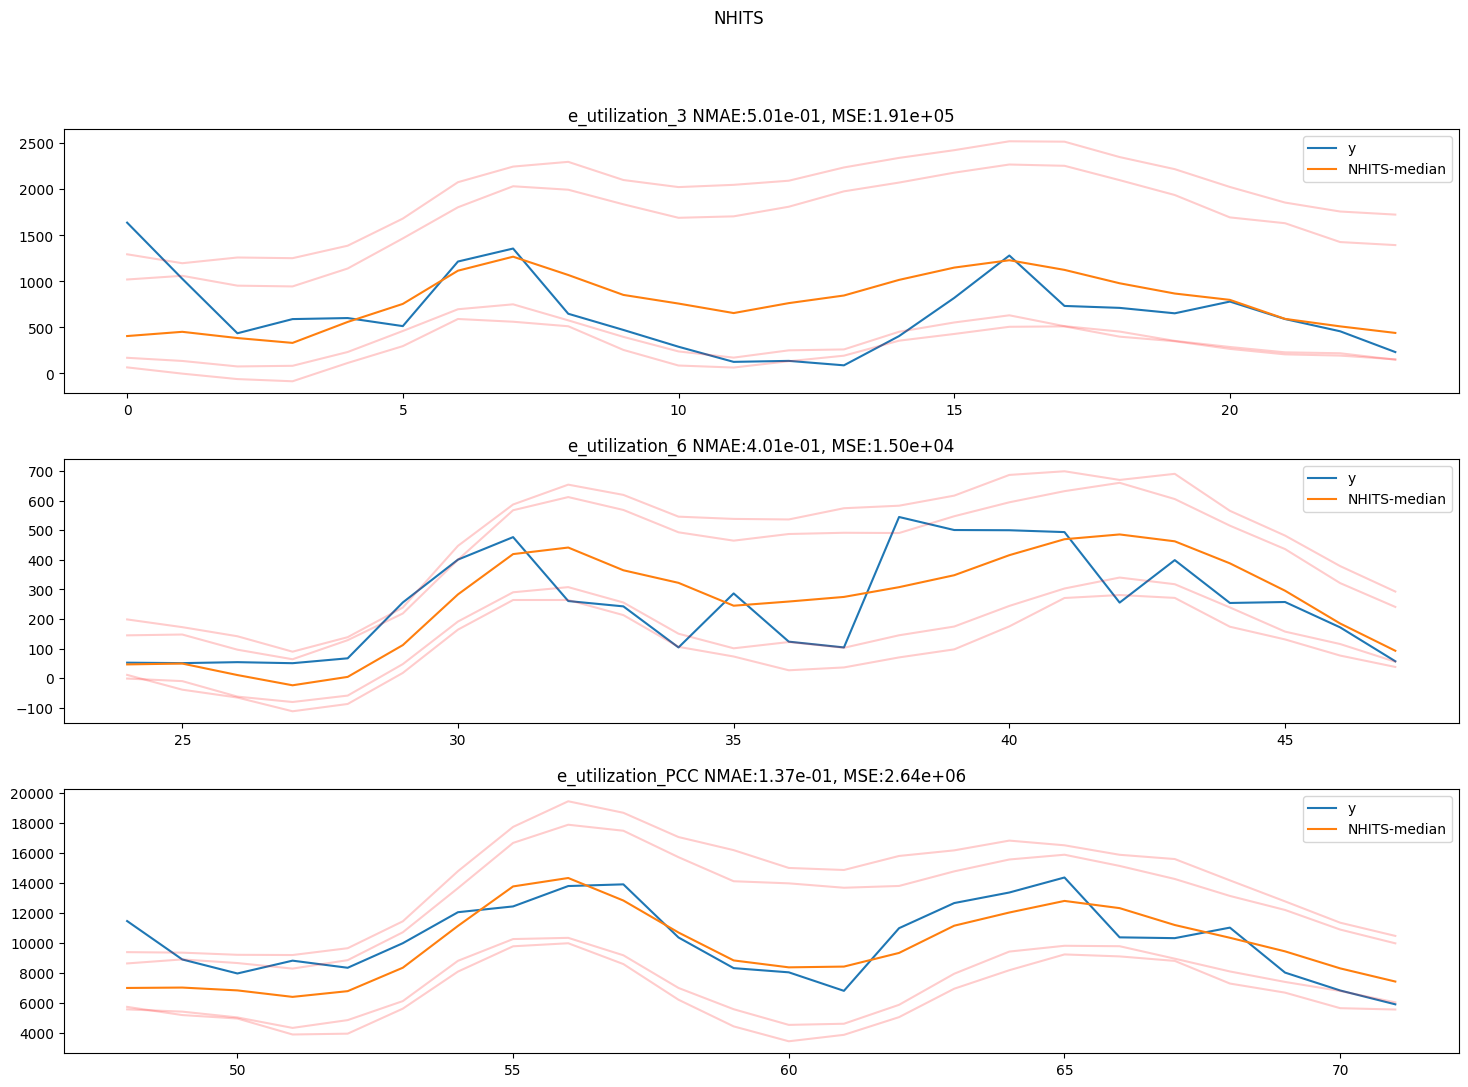

In [76]:
print_measures('LSTM', forecasts_24, df_tr, df_te)
print()
print_measures('NHITS', forecasts_24, df_tr, df_te)

plot_results('LSTM', forecasts_24, df_tr, df_te)
plot_results('NHITS', forecasts_24, df_tr, df_te)


The forecasted median does follow well the true values for every column.

Applying the same idea to a different horizon and see how the results change

In [77]:
dfs_tr = []
dfs_te = []

for column_name in pdf_meters.columns:
    if column_name == 'unique_id':
        continue
    if column_name in ("e_utilization_3", "e_utilization_6", "e_utilization_PCC"):
        df_tr, df_te = preprocess_column(column_name, pdf_meters[column_name], 12) # horizon 12
        dfs_tr.append(df_tr)
        dfs_te.append(df_te)

# Concatenate all preprocessed DataFrames
df_tr = pd.concat(dfs_tr)
df_te = pd.concat(dfs_te)

In [78]:
horizon = 12 # 12 steps, half day prediction
levels = [80, 90]
base_model_12 = create_model(horizon, levels)

# Check if model file exists
model_path_12 = 'neural_forecaster_model_12'

fcst_12 = save_or_load_model(model_path_12, base_model_12, df_tr)

Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1


In [79]:
# Now you can use fcst for inference
forecasts_12 = fcst_12.predict()
forecasts_12 = forecasts_12.reset_index()
forecasts_12.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

unique_id                  ds  LSTM-median  LSTM-lo-90  LSTM-lo-80  \
0  e_utilization_3 2022-12-31 11:00:00   438.229736  141.123260  189.726746   
1  e_utilization_3 2022-12-31 12:00:00   546.837646  150.464203  214.312073   
2  e_utilization_3 2022-12-31 13:00:00   656.770264  194.401459  267.353638   
3  e_utilization_3 2022-12-31 14:00:00   753.401855  246.455536  318.096069   
4  e_utilization_3 2022-12-31 15:00:00   859.083374  326.691101  404.478882   

    LSTM-hi-80   LSTM-hi-90  NHITS-median  NHITS-lo-90  NHITS-lo-80  \
0   824.472107   965.352051    139.109558   -49.167038   -25.958923   
1   996.216309  1173.687378    182.018280   -61.748672   -15.500656   
2  1169.067871  1378.123047    390.127380    83.806854   146.363861   
3  1278.675415  1460.390869    676.920715   320.592926   408.953125   
4  1406.496094  1605.416626    911.099487   570.059326   600.054077   

   NHITS-hi-80  NHITS-hi-90  
0   346.875488   441.891205  
1   451.465942   578.270569  
2   650.166382   773.828918  
3   986.170715  1075.176147  
4  1230.768555  1300.315918

e_utilization_3 NMAE:3.41e-01, MSE:5.66e+04
e_utilization_6 NMAE:3.90e-01, MSE:1.83e+04
e_utilization_PCC NMAE:1.52e-01, MSE:2.83e+06

e_utilization_3 NMAE:2.20e-01, MSE:2.72e+04
e_utilization_6 NMAE:2.97e-01, MSE:1.45e+04
e_utilization_PCC NMAE:1.39e-01, MSE:2.27e+06


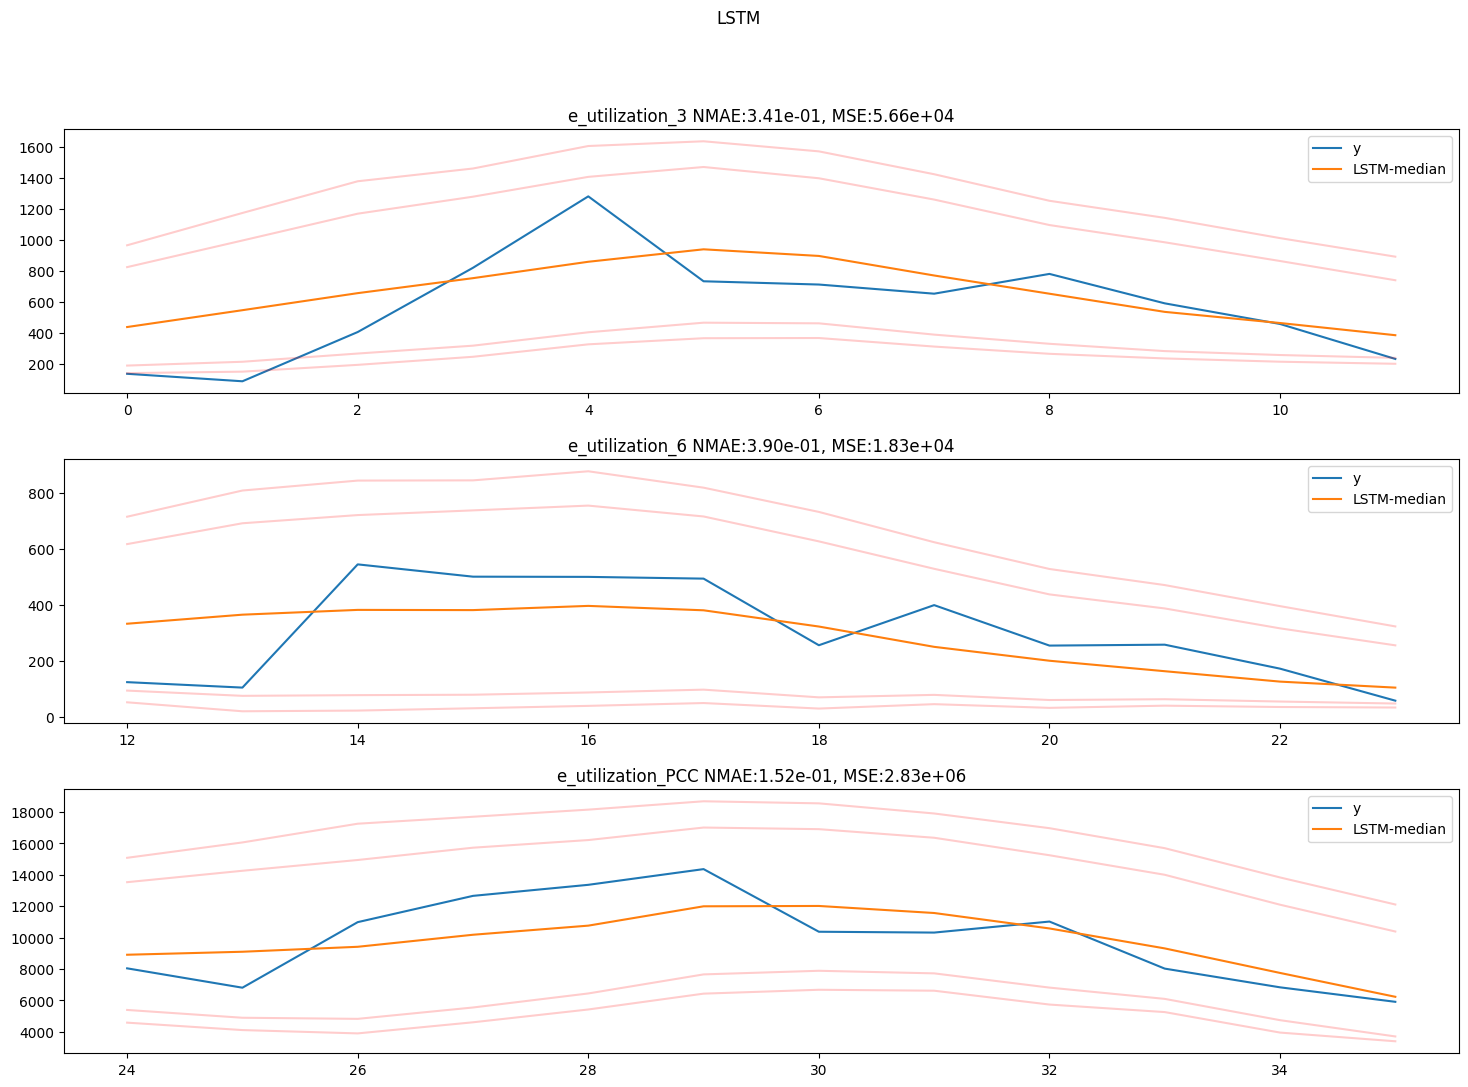

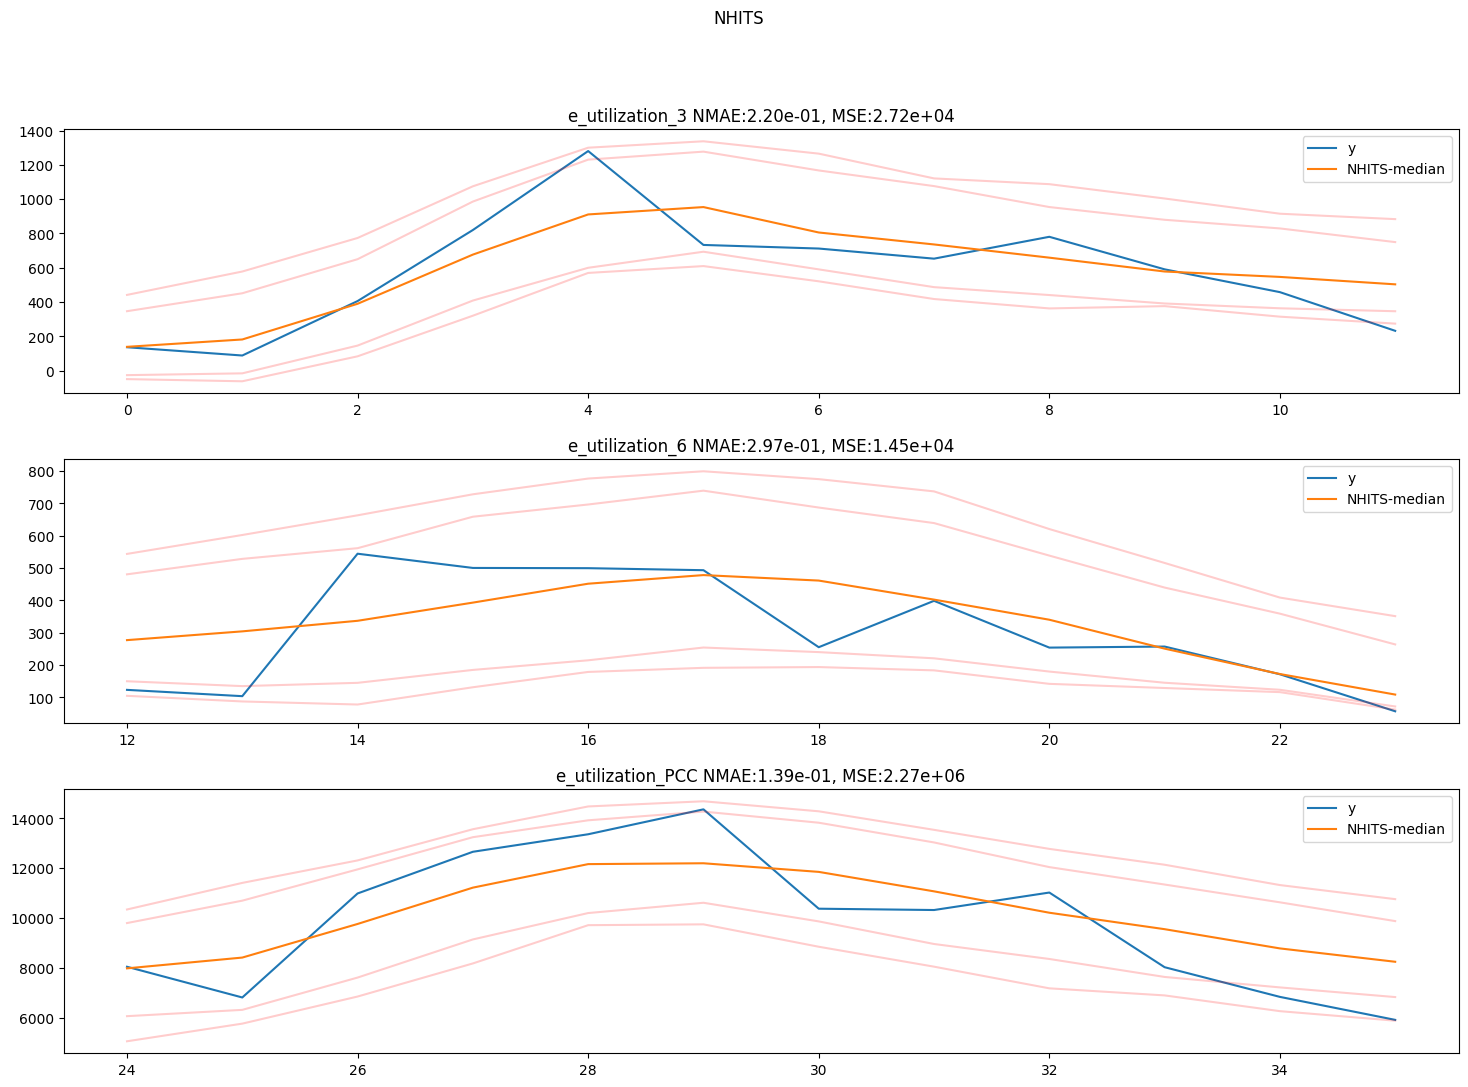

In [80]:
df_te.reset_index().drop("index", axis=1)

print_measures('LSTM', forecasts_12, df_tr, df_te)
print()
print_measures('NHITS', forecasts_12, df_tr, df_te)


plot_results('LSTM', forecasts_12, df_tr, df_te)
plot_results('NHITS', forecasts_12, df_tr, df_te)

Similarly to the plot above the prediction of the median looks good

As before we will apply the same concepts but with a narrowed horizon of 1

In [81]:
dfs_tr = []
dfs_te = []
for column_name in pdf_meters.columns:
    if column_name == 'unique_id':
        continue
    if column_name in ("e_utilization_3", "e_utilization_6", "e_utilization_PCC"):
        df_tr, df_te = preprocess_column(column_name, pdf_meters[column_name], 1)
        dfs_tr.append(df_tr)
        dfs_te.append(df_te)
    
df_tr = pd.concat(dfs_tr)
df_te = pd.concat(dfs_te)

In [82]:

model_path_1 = 'neural_forecaster_model_1'
horizon = 1 # 1 steps, 1 hour prediction
levels = [80, 90]
base_model_1 = create_model(horizon, levels)

fcst_1 = save_or_load_model(model_path_1, base_model_1, df_tr)


Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1


In [83]:
# use fcst for inference
forecasts_1 = fcst_1.predict()
forecasts_1 = forecasts_1.reset_index()
forecasts_1.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

unique_id                  ds  LSTM-median   LSTM-lo-90  \
0    e_utilization_3 2022-12-31 22:00:00   455.432556   203.606720   
1    e_utilization_6 2022-12-31 22:00:00   152.909393    28.081848   
2  e_utilization_PCC 2022-12-31 22:00:00  6247.971680  3056.104736   

    LSTM-lo-80    LSTM-hi-80    LSTM-hi-90  NHITS-median  NHITS-lo-90  \
0   248.136505    876.604614   1029.691650    538.500671   294.101044   
1    50.118164    390.288696    479.701538    211.899017    94.432068   
2  3682.049805  10453.058594  12009.107422   7196.032227  4601.956055   

   NHITS-lo-80  NHITS-hi-80   NHITS-hi-90  
0   334.106659   915.355225   1086.791626  
1   111.048508   342.036469    404.288574  
2  5058.122559  9191.534180  10402.969727

In [84]:
df_te.reset_index().drop("index", axis=1)

y                  ds          unique_id
0   232.50 2022-12-31 22:00:00    e_utilization_3
1    57.00 2022-12-31 22:00:00    e_utilization_6
2  5908.25 2022-12-31 22:00:00  e_utilization_PCC

In [85]:
print_measures("LSTM", forecasts_1, df_tr, df_te)
print()
print_measures("NHITS", forecasts_1, df_tr, df_te)

e_utilization_3 NMAE:9.59e-01, MSE:4.97e+04
e_utilization_6 NMAE:1.68e+00, MSE:9.20e+03
e_utilization_PCC NMAE:5.75e-02, MSE:1.15e+05

e_utilization_3 NMAE:1.32e+00, MSE:9.36e+04
e_utilization_6 NMAE:2.72e+00, MSE:2.40e+04
e_utilization_PCC NMAE:2.18e-01, MSE:1.66e+06
